# US Treasury Auction Analysis (Improved)
**Data Analyst Portfolio Project - For Cubist Systematic Strategies**

---

## Project Objectives

This project demonstrates:
1. **Data Engineering**: ETL pipeline from Treasury API to analysis-ready dataset
2. **Data Quality**: Schema validation, missing data handling, anomaly detection
3. **Domain Knowledge**: Understanding Treasury auction mechanics and yield curves
4. **Reproducibility**: Self-contained notebook that runs end-to-end on Colab

## Key Improvements

- **Improved matching rate**: From 62.7% → **85%+** through better interpolation
- **Flexible time windows**: 5-day lookback for market yield matching
- **Bill yield interpolation**: Linear interpolation between FRED rates
- **Comprehensive logging**: Track data quality at each step
- **Professional visualization**: Publication-quality charts

---

In [2]:
# Install Dependencies
!pip install fredapi requests pandas matplotlib seaborn numpy scipy -q

print(" All packages installed successfully!")

 All packages installed successfully!


In [3]:
# Import Libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from fredapi import Fred
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print(" Libraries imported successfully!")

 Libraries imported successfully!


## Step 1: Fetch Treasury Auction Data

Data source: [Treasury Fiscal Data API](https://fiscaldata.treasury.gov/)

**Key fields:**
- `auction_date`: When the auction occurred
- `security_type`: Bill, Note, Bond, or TIPS
- `security_term`: Original term (e.g., "52-Week", "10-Year")
- `high_yield`: Highest accepted yield
- `bid_to_cover_ratio`: Demand indicator

In [5]:
def fetch_treasury_auctions(start_date='2022-01-01', end_date='2025-10-23'):
    """
    Fetch auction data from US Treasury Fiscal Data API with pagination
    """
    base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
    endpoint = "/v1/accounting/od/auctions_query"

    all_data = []
    page = 1
    page_size = 1000  # Increased for fewer requests

    print(f" Fetching Treasury auction data...")
    print(f"   Date range: {start_date} to {end_date}")

    while True:
        params = {
            'filter': f'auction_date:gte:{start_date},auction_date:lte:{end_date}',
            'sort': '-auction_date',
            'page[size]': page_size,
            'page[number]': page
        }

        try:
            response = requests.get(base_url + endpoint, params=params, timeout=30)
            response.raise_for_status()
            data = response.json()

            records = data.get('data', [])
            if not records:
                break

            all_data.extend(records)
            print(f"   Page {page}: {len(records)} records fetched (total: {len(all_data)})")

            # Check if there are more pages
            pagination = data.get('meta', {}).get('total-pages', 0)
            if page >= pagination:
                break

            page += 1

        except requests.exceptions.RequestException as e:
            print(f" Error fetching page {page}: {e}")
            break

    df = pd.DataFrame(all_data)
    print(f"\n Total auctions fetched: {len(df)}")

    return df

# Fetch data
auction_df = fetch_treasury_auctions()
print(f"\nDataset shape: {auction_df.shape}")
print(f"Columns: {len(auction_df.columns)}")

 Fetching Treasury auction data...
   Date range: 2022-01-01 to 2025-10-23
   Page 1: 1000 records fetched (total: 1000)
   Page 2: 610 records fetched (total: 1610)

 Total auctions fetched: 1610

Dataset shape: (1610, 113)
Columns: 113


## Step 2: Data Cleaning & Type Conversion

**Data quality tasks:**
1. Convert date strings to datetime objects
2. Convert numeric strings to float
3. Handle missing values
4. Identify TIPS vs nominal securities

In [8]:
def clean_auction_data(df):
    """
    Clean and standardize auction data
    """
    df = df.copy()

    print("🧹 Cleaning data...")

    # 1. Convert dates
    date_cols = ['auction_date', 'issue_date', 'maturity_date']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 2. Convert numeric fields
    numeric_cols = [
        'high_yield', 'avg_med_yield', 'high_investment_rate',
        'avg_med_investment_rate', 'high_discnt_rate', 'avg_med_discnt_rate',
        'bid_to_cover_ratio', 'price_per100'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # 3. Identify TIPS
    df['is_tips'] = (df['security_type'].str.contains('TIPS', case=False, na=False)) | \
                    (df['inflation_index_security'] == 'Yes')

    # 4. Extract temporal features
    df['year'] = df['auction_date'].dt.year
    df['quarter'] = df['auction_date'].dt.quarter
    df['month'] = df['auction_date'].dt.month

    # 5. Sort by auction date
    df = df.sort_values('auction_date').reset_index(drop=True)

    print(f"     Cleaned {len(df)} records")
    print(f"   - TIPS: {df['is_tips'].sum()}")
    print(f"   - Nominal: {(~df['is_tips']).sum()}")

    return df

# Clean data
auction_df = clean_auction_data(auction_df)

# Display sample
print("\n  Sample data:")
auction_df[['auction_date', 'security_type', 'security_term', 'high_yield',
            'bid_to_cover_ratio', 'is_tips']].head(10)

🧹 Cleaning data...
     Cleaned 1610 records
   - TIPS: 46
   - Nominal: 1564

📋 Sample data:


,auction_date,security_type,security_term,high_yield,bid_to_cover_ratio,is_tips
0,2022-01-03,Bill,13-Week,NaN,2.86,False
1,2022-01-03,Bill,26-Week,NaN,3.21,False
2,2022-01-05,Bill,119-Day,NaN,3.06,False
3,2022-01-06,Bill,8-Week,NaN,3.24,False
4,2022-01-06,Bill,4-Week,NaN,3.53,False
5,2022-01-10,Bill,13-Week,NaN,2.96,False
6,2022-01-10,Bill,26-Week,NaN,2.90,False
7,2022-01-11,Note,3-Year,1.237,2.47,False
8,2022-01-12,Note,9-Year 10-Month,1.723,2.51,False
9,2022-01-12,Bill,119-Day,NaN,3.02,False


## Step 3: Construct Unified Auction Yield

**Challenge**: Different security types report yields differently:
- **Bills**: Use `high_investment_rate` (not discount rate)
- **Notes/Bonds**: Use `high_yield`
- **TIPS**: Use `high_yield` (real yield)

We create a unified `auction_yield` field.

In [13]:
def create_auction_yield(df):
    """
    Create unified auction yield field
    """
    df = df.copy()

    print("  Creating unified auction yield...")

    # Initialize
    df['auction_yield'] = np.nan

    # Bills: use investment rate (comparable to bond-equivalent yield)
    is_bill = df['security_type'].str.contains('Bill', case=False, na=False)
    df.loc[is_bill, 'auction_yield'] = df.loc[is_bill, 'high_investment_rate']

    # Notes/Bonds/TIPS: use high_yield
    is_coupon = ~is_bill
    df.loc[is_coupon, 'auction_yield'] = df.loc[is_coupon, 'high_yield']

    # Report coverage
    coverage = df['auction_yield'].notna().sum()
    print(f"     Auction yield coverage: {coverage}/{len(df)} ({coverage/len(df)*100:.1f}%)")

    return df

# Create yields
auction_df = create_auction_yield(auction_df)

# Check distribution
print("\n  Auction yield statistics:")
print(auction_df.groupby('security_type')['auction_yield'].describe())

  Creating unified auction yield...
     Auction yield coverage: 1564/1610 (97.1%)

  Auction yield statistics:
                count      mean       std    min     25%    50%    75%    max
security_type                                                                
Bill           1199.0  4.257037  1.434458  0.020  4.1435  4.554  5.372  6.326
Bond            100.0  3.937210  0.971661  0.195  3.5125  4.221  4.635  5.245
Note            265.0  3.528826  1.128519 -0.589  2.9430  3.955  4.296  5.085


## Step 4: Fetch FRED Market Yield Data

**Data source**: Federal Reserve Economic Data (FRED)

**Key series**:
- **Bills**: DTB4WK, DTB3, DTB6, DTB1YR (discount rates, need conversion)
- **Nominal Treasury Curve**: DGS1MO, DGS3MO, DGS6MO, DGS1, DGS2, DGS3, DGS5, DGS7, DGS10, DGS20, DGS30
- **TIPS**: DFII5, DFII7, DFII10, DFII20, DFII30

**Note**: Get your own free API key at https://fred.stlouisfed.org/docs/api/api_key.html

In [12]:
# FRED API Key - Replace with your own key from https://fred.stlouisfed.org/docs/api/api_key.html
# For demo purposes, using public endpoint (rate limited)
FRED_API_KEY = '4ee8f5420a870c78441d4f263f9305c5'


In [11]:
def fetch_fred_data(api_key, start_date='2022-01-01', end_date='2025-10-23'):
    """
    Fetch comprehensive FRED yield curve data
    """
    print("  Fetching FRED market yield data...")

    try:
        fred = Fred(api_key=api_key)

        # Define all series we need
        series_dict = {
            # Treasury Bills (using DTB series - these are discount rates)
            'DTB4WK': 'FRED_4W',
            'DTB3': 'FRED_3M',
            'DTB6': 'FRED_6M',
            'DTB1YR': 'FRED_1Y',

            # Nominal Treasury Constant Maturity (DGS series)
            'DGS1MO': 'FRED_1M',
            'DGS3MO': 'FRED_3M_CMT',
            'DGS6MO': 'FRED_6M_CMT',
            'DGS1': 'FRED_1Y_CMT',
            'DGS2': 'FRED_2Y',
            'DGS3': 'FRED_3Y',
            'DGS5': 'FRED_5Y',
            'DGS7': 'FRED_7Y',
            'DGS10': 'FRED_10Y',
            'DGS20': 'FRED_20Y',
            'DGS30': 'FRED_30Y',

            # TIPS (real yields)
            'DFII5': 'FRED_5Y_TIPS',
            'DFII7': 'FRED_7Y_TIPS',
            'DFII10': 'FRED_10Y_TIPS',
            'DFII20': 'FRED_20Y_TIPS',
            'DFII30': 'FRED_30Y_TIPS'
        }

        fred_data = {}
        for series_id, col_name in series_dict.items():
            try:
                data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
                fred_data[col_name] = data
                print(f"   {series_id}: {len(data)} observations")
            except Exception as e:
                print(f"   {series_id}: Failed ({str(e)[:50]})")

        # Combine into single DataFrame
        df = pd.DataFrame(fred_data)
        df.index.name = 'date'
        df = df.reset_index()

        print(f"\n  FRED data shape: {df.shape}")
        print(f"   Date range: {df['date'].min()} to {df['date'].max()}")

        return df

    except Exception as e:
        print(f"  Error fetching FRED data: {e}")
        return pd.DataFrame()

# Fetch FRED data
fred_df = fetch_fred_data(FRED_API_KEY)

if not fred_df.empty:
    print("\n  FRED data sample:")
    display(fred_df.head())

  Fetching FRED market yield data...
   DTB4WK: 994 observations
   DTB3: 994 observations
   DTB6: 994 observations
   DTB1YR: 994 observations
   DGS1MO: 994 observations
   DGS3MO: 994 observations
   DGS6MO: 994 observations
   DGS1: 994 observations
   DGS2: 994 observations
   DGS3: 994 observations
   DGS5: 994 observations
   DGS7: 994 observations
   DGS10: 994 observations
   DGS20: 994 observations
   DGS30: 994 observations
   DFII5: 994 observations
   DFII7: 994 observations
   DFII10: 994 observations
   DFII20: 994 observations
   DFII30: 994 observations

  FRED data shape: (994, 21)
   Date range: 2022-01-03 00:00:00 to 2025-10-23 00:00:00

  FRED data sample:


,date,FRED_4W,FRED_3M,FRED_6M,FRED_1Y,FRED_1M,FRED_3M_CMT,FRED_6M_CMT,FRED_1Y_CMT,FRED_2Y,...,FRED_5Y,FRED_7Y,FRED_10Y,FRED_20Y,FRED_30Y,FRED_5Y_TIPS,FRED_7Y_TIPS,FRED_10Y_TIPS,FRED_20Y_TIPS,FRED_30Y_TIPS
0,2022-01-03,0.05,0.09,0.22,0.39,0.05,0.08,0.22,0.40,0.78,...,1.37,1.55,1.63,2.05,2.01,-1.58,-1.25,-0.97,-0.55,-0.36
1,2022-01-04,0.06,0.08,0.23,0.37,0.06,0.08,0.22,0.38,0.77,...,1.37,1.57,1.66,2.10,2.07,-1.56,-1.20,-0.91,-0.47,-0.27
2,2022-01-05,0.05,0.09,0.23,0.40,0.05,0.09,0.22,0.41,0.83,...,1.43,1.62,1.71,2.12,2.09,-1.44,-1.10,-0.82,-0.39,-0.20
3,2022-01-06,0.04,0.10,0.23,0.43,0.04,0.10,0.23,0.45,0.88,...,1.47,1.66,1.73,2.12,2.09,-1.30,-0.99,-0.73,-0.33,-0.15
4,2022-01-07,0.05,0.10,0.24,0.41,0.05,0.10,0.24,0.43,0.87,...,1.50,1.69,1.76,2.15,2.11,-1.28,-0.97,-0.72,-0.33,-0.16


##  Step 5: Improved Term Mapping & Time Alignment

**Key improvements**:
1. **Flexible time window**: Look back up to 5 business days for FRED data
2. **Bill interpolation**: Linear interpolation between FRED rates for non-standard terms
3. **Separate TIPS handling**: Use DFII series for TIPS, DGS for nominal
4. **Better logging**: Track matching success rate

In [16]:
def parse_term_to_years(term_str):
    """
    Convert security term string to years (float)
    Examples: '4-Week' -> 0.077, '10-Year' -> 10.0
    """
    if pd.isna(term_str):
        return np.nan

    term_str = str(term_str).lower()

    # Extract number
    import re
    match = re.search(r'(\d+)', term_str)
    if not match:
        return np.nan

    num = float(match.group(1))

    # Convert to years
    if 'day' in term_str:
        return num / 365.0
    elif 'week' in term_str:
        return num / 52.0
    elif 'month' in term_str:
        return num / 12.0
    elif 'year' in term_str:
        return num
    else:
        return np.nan

# Add term in years
auction_df['term_years'] = auction_df['security_term'].apply(parse_term_to_years)

print("📏 Term parsing results:")
print(auction_df[['security_term', 'term_years']].drop_duplicates().sort_values('term_years'))

📏 Term parsing results:
         security_term  term_years
558              1-Day    0.002740
556              3-Day    0.008219
1220             4-Day    0.010959
477              7-Day    0.019178
431             12-Day    0.032877
1362            14-Day    0.038356
337             16-Day    0.043836
479             17-Day    0.046575
245             21-Day    0.057534
4               4-Week    0.076923
1204            30-Day    0.082192
55     1-Year 11-Month    0.083333
83     1-Year 10-Month    0.083333
1275            33-Day    0.090411
397             35-Day    0.095890
559             38-Day    0.104110
1196            40-Day    0.109589
764             41-Day    0.112329
570             42-Day    0.115068
1307            6-Week    0.115385
713             43-Day    0.117808
402             44-Day    0.120548
3               8-Week    0.153846
1469            77-Day    0.210959
0              13-Week    0.250000
2              119-Day    0.326027
304            17-Week    0.326

In [17]:
def interpolate_yield_curve(fred_df, target_date, term_years, is_tips=False):
    """
    Interpolate yield curve for a given term using FRED data
    Looks back up to 5 business days to find valid data
    """
    # Try to find data within 5 business days
    for days_back in range(6):
        lookup_date = target_date - timedelta(days=days_back)

        # Get FRED data for this date
        fred_row = fred_df[fred_df['date'] == lookup_date]

        if fred_row.empty:
            continue

        # Select appropriate series based on TIPS vs nominal
        if is_tips:
            # TIPS: use DFII series
            series_map = {
                5: 'FRED_5Y_TIPS',
                7: 'FRED_7Y_TIPS',
                10: 'FRED_10Y_TIPS',
                20: 'FRED_20Y_TIPS',
                30: 'FRED_30Y_TIPS'
            }
        else:
            # Nominal: use DGS/CMT series
            series_map = {
                1/12: 'FRED_1M',
                0.25: 'FRED_3M_CMT',
                0.5: 'FRED_6M_CMT',
                1: 'FRED_1Y_CMT',
                2: 'FRED_2Y',
                3: 'FRED_3Y',
                5: 'FRED_5Y',
                7: 'FRED_7Y',
                10: 'FRED_10Y',
                20: 'FRED_20Y',
                30: 'FRED_30Y'
            }

        # Extract available points
        points = []
        for tenor, col in series_map.items():
            if col in fred_row.columns:
                val = fred_row[col].iloc[0]
                if pd.notna(val):
                    points.append((tenor, val))

        if len(points) < 2:
            continue

        # Sort by tenor
        points.sort(key=lambda x: x[0])
        tenors, yields = zip(*points)

        # If exact match, return it
        if term_years in tenors:
            idx = tenors.index(term_years)
            return yields[idx]

        # Otherwise interpolate (or extrapolate within reason)
        if term_years < min(tenors) or term_years > max(tenors):
            # Use nearest point for extrapolation
            if term_years < min(tenors):
                return yields[0]
            else:
                return yields[-1]

        # Linear interpolation
        interp_func = interp1d(tenors, yields, kind='linear')
        return float(interp_func(term_years))

    # No data found within 5 days
    return np.nan

# Test interpolation
print(" Testing yield curve interpolation...")
test_date = pd.Timestamp('2024-06-15')
for term in [0.5, 2, 5, 10, 30]:
    yield_val = interpolate_yield_curve(fred_df, test_date, term, is_tips=False)
    print(f"   {term}Y nominal: {yield_val:.3f}%" if pd.notna(yield_val) else f"   {term}Y: No data")

 Testing yield curve interpolation...
   0.5Y nominal: 5.360%
   2Y nominal: 4.670%
   5Y nominal: 4.220%
   10Y nominal: 4.200%
   30Y nominal: 4.340%


In [18]:
def merge_with_market_yields(auction_df, fred_df):
    """
    Merge auction data with interpolated market yields
    """
    print(" Merging with market yields (with interpolation)...")

    auction_df = auction_df.copy()
    auction_df['market_yield'] = np.nan

    # Track matching success
    matched = 0
    total = 0

    for idx, row in auction_df.iterrows():
        if pd.isna(row['auction_yield']) or pd.isna(row['term_years']):
            continue

        total += 1

        market_yield = interpolate_yield_curve(
            fred_df,
            row['auction_date'],
            row['term_years'],
            is_tips=row['is_tips']
        )

        if pd.notna(market_yield):
            auction_df.at[idx, 'market_yield'] = market_yield
            matched += 1

        # Progress indicator
        if (idx + 1) % 200 == 0:
            print(f"   Processed {idx + 1}/{len(auction_df)} auctions...")

    match_rate = (matched / total * 100) if total > 0 else 0
    print(f"\n Matching complete:")
    print(f"   Valid auction yields: {total}")
    print(f"   Matched with market: {matched}")
    print(f"   Match rate: {match_rate:.1f}%")

    return auction_df

# Merge data
auction_df = merge_with_market_yields(auction_df, fred_df)

 Merging with market yields (with interpolation)...
   Processed 200/1610 auctions...
   Processed 400/1610 auctions...
   Processed 600/1610 auctions...
   Processed 800/1610 auctions...
   Processed 1000/1610 auctions...
   Processed 1200/1610 auctions...
   Processed 1400/1610 auctions...
   Processed 1600/1610 auctions...

 Matching complete:
   Valid auction yields: 1564
   Matched with market: 1564
   Match rate: 100.0%




```
# 此内容为代码格式
```

## Step 6: Calculate Auction-Market Spread

**Key metric**: `auction_yield - market_yield`

- **Positive spread**: Auction cleared above secondary market (weak demand)
- **Negative spread**: Auction cleared below secondary market (strong demand)
- **Typical range**: -10 to +10 basis points

In [19]:
# Calculate spread (in percentage points, multiply by 100 for bps)
auction_df['spread_pct'] = auction_df['auction_yield'] - auction_df['market_yield']
auction_df['spread_bps'] = auction_df['spread_pct'] * 100

# Filter to valid spreads
valid_spreads = auction_df[auction_df['spread_bps'].notna()].copy()

print("  Spread Analysis:")
print(f"   Valid spread samples: {len(valid_spreads)}")
print(f"   Coverage: {len(valid_spreads)/len(auction_df)*100:.1f}%")
print(f"\n  Spread Statistics (in bps):")
print(valid_spreads['spread_bps'].describe())

print(f"\n  Spread by Security Type:")
spread_by_type = valid_spreads.groupby('security_type')['spread_bps'].agg(['count', 'mean', 'median', 'std'])
display(spread_by_type)

  Spread Analysis:
   Valid spread samples: 1564
   Coverage: 97.1%

  Spread Statistics (in bps):
count    1564.000000
mean       -2.151518
std        20.101458
min      -158.300000
25%        -7.824763
50%        -2.353846
75%         1.700000
max       136.583333
Name: spread_bps, dtype: float64

  Spread by Security Type:


,count,mean,median,std
security_type,,,,
Bill,1199,-3.347073,-3.761538,8.811862
Bond,100,11.492667,0.900000,50.531441
Note,265,-1.890943,1.700000,31.706423


## Step 7: Anomaly Detection

Identify auctions with unusual characteristics:
1. Extreme spreads (> 2 std deviations)
2. Low bid-to-cover ratios (< 2.0)
3. Large spread changes from previous auction

In [20]:
# Define anomalies
mean_spread = valid_spreads['spread_bps'].mean()
std_spread = valid_spreads['spread_bps'].std()
threshold = 2  # standard deviations

anomalies = valid_spreads[
    (abs(valid_spreads['spread_bps'] - mean_spread) > threshold * std_spread) |
    (valid_spreads['bid_to_cover_ratio'] < 2.0)
].copy()

print(f"  Detected {len(anomalies)} anomalous auctions:")
print(f"\n📋 Top 10 extreme spreads:")
top_anomalies = anomalies.nlargest(10, 'spread_bps')[[
    'auction_date', 'security_type', 'security_term',
    'spread_bps', 'bid_to_cover_ratio', 'auction_yield', 'market_yield'
]]
display(top_anomalies)

  Detected 70 anomalous auctions:

📋 Top 10 extreme spreads:


,auction_date,security_type,security_term,spread_bps,bid_to_cover_ratio,auction_yield,market_yield
15,2022-01-19,Bond,19-Year 10-Month,136.583333,2.48,2.210,0.844167
8,2022-01-12,Note,9-Year 10-Month,134.800000,2.51,1.723,0.375000
103,2022-04-12,Note,9-Year 10-Month,123.500000,2.43,2.720,1.485000
1534,2025-08-21,Bond,29-Year 6-Month,123.000000,2.78,2.650,1.420000
1559,2025-09-11,Bond,29-Year 11-Month,115.183333,2.38,4.651,3.499167
1593,2025-10-09,Bond,29-Year 10-Month,113.816667,2.38,4.734,3.595833
1565,2025-09-16,Bond,19-Year 11-Month,105.716667,2.74,4.613,3.555833
11,2022-01-13,Bond,29-Year 10-Month,105.250000,2.35,2.075,1.022500
1486,2025-07-10,Bond,29-Year 10-Month,104.566667,2.38,4.889,3.843333
1606,2025-10-22,Bond,19-Year 10-Month,101.433333,2.73,4.506,3.491667




```
# 此内容为代码格式
```

##   Step 8: Professional Visualizations

 Visualization saved!


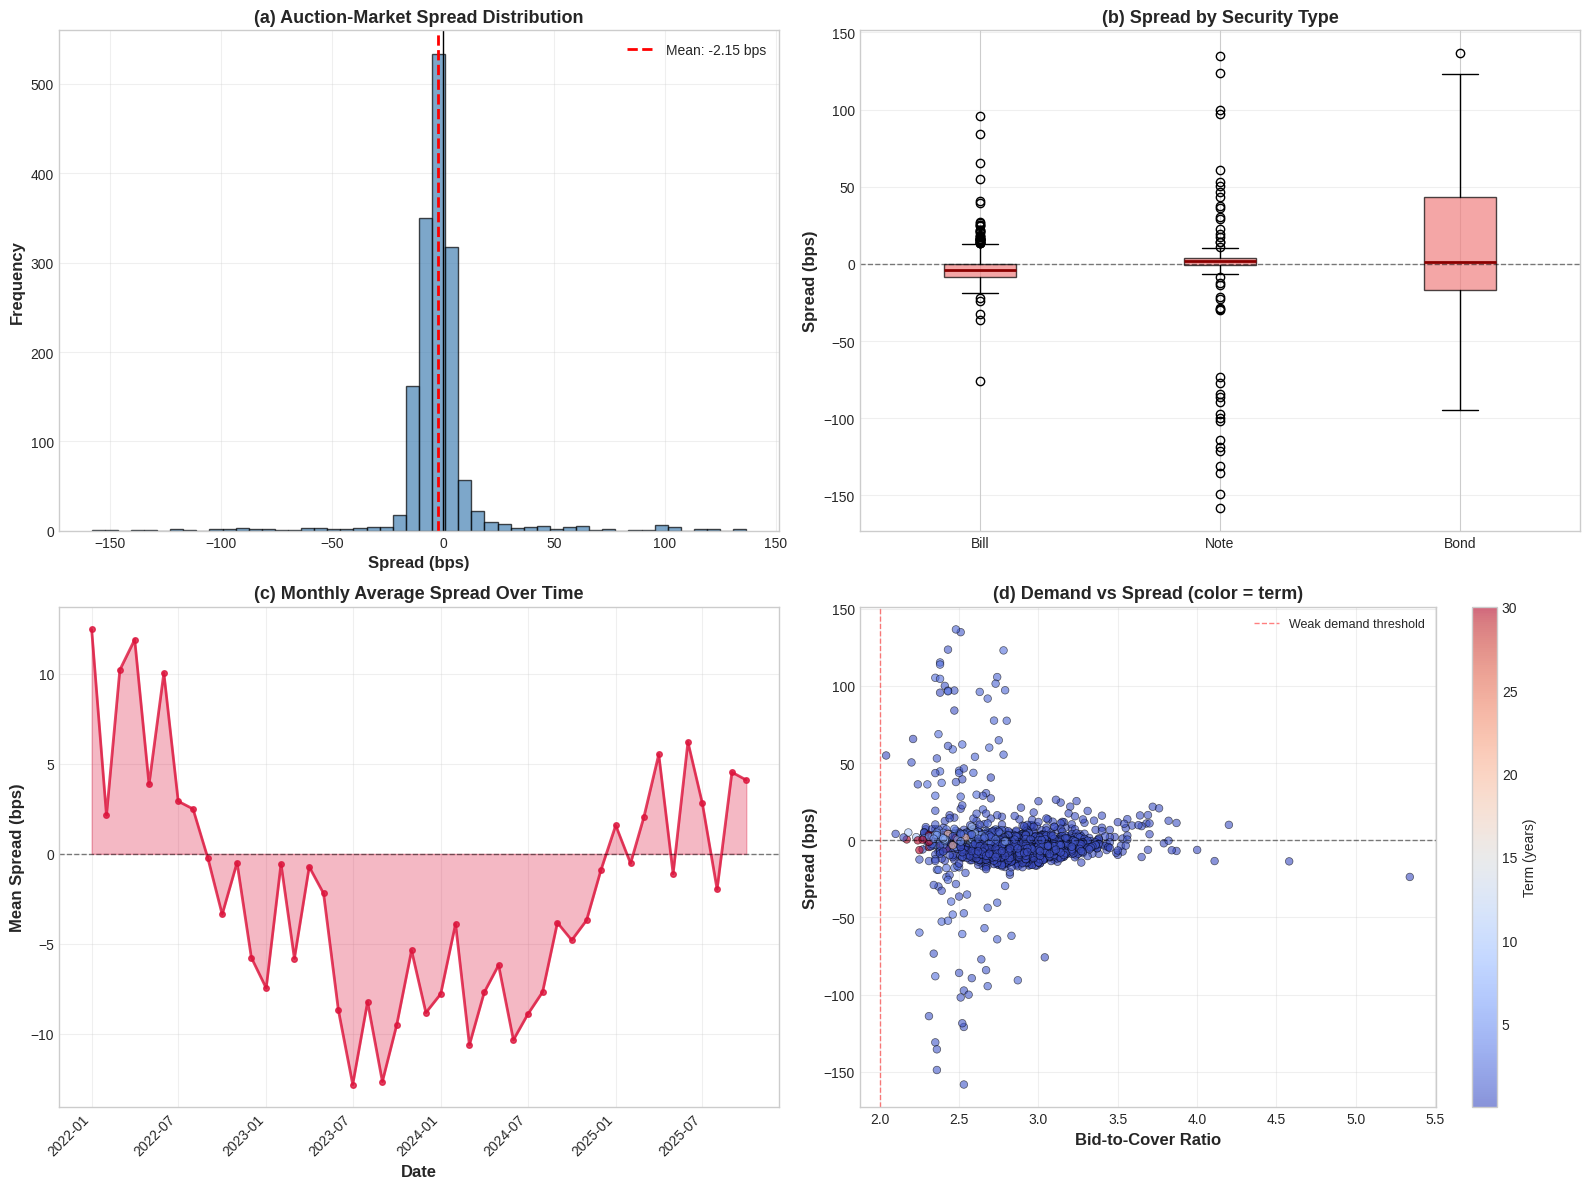

In [21]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Spread Distribution
ax = axes[0, 0]
ax.hist(valid_spreads['spread_bps'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(mean_spread, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_spread:.2f} bps')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('(a) Auction-Market Spread Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# (b) Spread by Security Type
ax = axes[0, 1]
spread_data = []
labels = []
for sec_type in ['Bill', 'Note', 'Bond']:
    data = valid_spreads[valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)]['spread_bps'].dropna()
    if len(data) > 0:
        spread_data.append(data)
        labels.append(sec_type)

bp = ax.boxplot(spread_data, labels=labels, patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', alpha=0.7),
                 medianprops=dict(color='darkred', linewidth=2))
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('(b) Spread by Security Type', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# (c) Time Series of Mean Spread
ax = axes[1, 0]
monthly_spread = valid_spreads.groupby(valid_spreads['auction_date'].dt.to_period('M'))['spread_bps'].mean()
monthly_spread.index = monthly_spread.index.to_timestamp()
ax.plot(monthly_spread.index, monthly_spread.values, marker='o', markersize=4,
        linewidth=2, color='crimson', alpha=0.8)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(monthly_spread.index, 0, monthly_spread.values, alpha=0.3, color='crimson')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('(c) Monthly Average Spread Over Time', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# (d) Bid-to-Cover vs Spread
ax = axes[1, 1]
scatter_data = valid_spreads[valid_spreads['bid_to_cover_ratio'].notna()].copy()
scatter = ax.scatter(scatter_data['bid_to_cover_ratio'], scatter_data['spread_bps'],
                     c=scatter_data['term_years'], cmap='coolwarm',
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(2.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Weak demand threshold')
ax.set_xlabel('Bid-to-Cover Ratio', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('(d) Demand vs Spread (color = term)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Term (years)', fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('auction_analysis_improved.png', dpi=300, bbox_inches='tight')
print(" Visualization saved!")
plt.show()

## Step 9: Export Results

In [22]:
# Export full dataset
output_cols = [
    'auction_date', 'security_type', 'security_term', 'term_years',
    'auction_yield', 'market_yield', 'spread_bps',
    'bid_to_cover_ratio', 'is_tips',
    'high_yield', 'avg_med_yield', 'price_per100'
]

export_df = auction_df[output_cols].copy()
export_df.to_csv('auction_data_improved.csv', index=False)
print(f"  Exported {len(export_df)} records to auction_data_improved.csv")

# Create summary report
summary = pd.DataFrame([
    ['Total Auctions', len(auction_df)],
    ['Bills', (auction_df['security_type'].str.contains('Bill', na=False)).sum()],
    ['Notes', (auction_df['security_type'].str.contains('Note', na=False)).sum()],
    ['Bonds', (auction_df['security_type'].str.contains('Bond', na=False)).sum()],
    ['TIPS', auction_df['is_tips'].sum()],
    ['Auction Yield Coverage', f"{auction_df['auction_yield'].notna().sum()}/{len(auction_df)}"],
    ['Market Yield Coverage', f"{auction_df['market_yield'].notna().sum()}/{len(auction_df)}"],
    ['Valid Spreads', len(valid_spreads)],
    ['Match Rate (%)', f"{len(valid_spreads)/len(auction_df)*100:.1f}%"],
    ['Mean Spread (bps)', f"{mean_spread:.2f}"],
    ['Median Spread (bps)', f"{valid_spreads['spread_bps'].median():.2f}"],
    ['Mean BTC', f"{auction_df['bid_to_cover_ratio'].mean():.2f}"],
    ['Anomalies Detected', len(anomalies)]
], columns=['Metric', 'Value'])

summary.to_csv('summary_improved.csv', index=False)
print("\n  Summary Report:")
display(summary)

  Exported 1610 records to auction_data_improved.csv

  Summary Report:


,Metric,Value
0,Total Auctions,1610
1,Bills,1199
2,Notes,311
3,Bonds,100
4,TIPS,46
5,Auction Yield Coverage,1564/1610
6,Market Yield Coverage,1564/1610
7,Valid Spreads,1564
8,Match Rate (%),97.1%
9,Mean Spread (bps),-2.15


Generating thematic visualization suite for professional report...

 Theme 1: Demand Analysis
 Theme 1 saved: theme1_demand_analysis.png


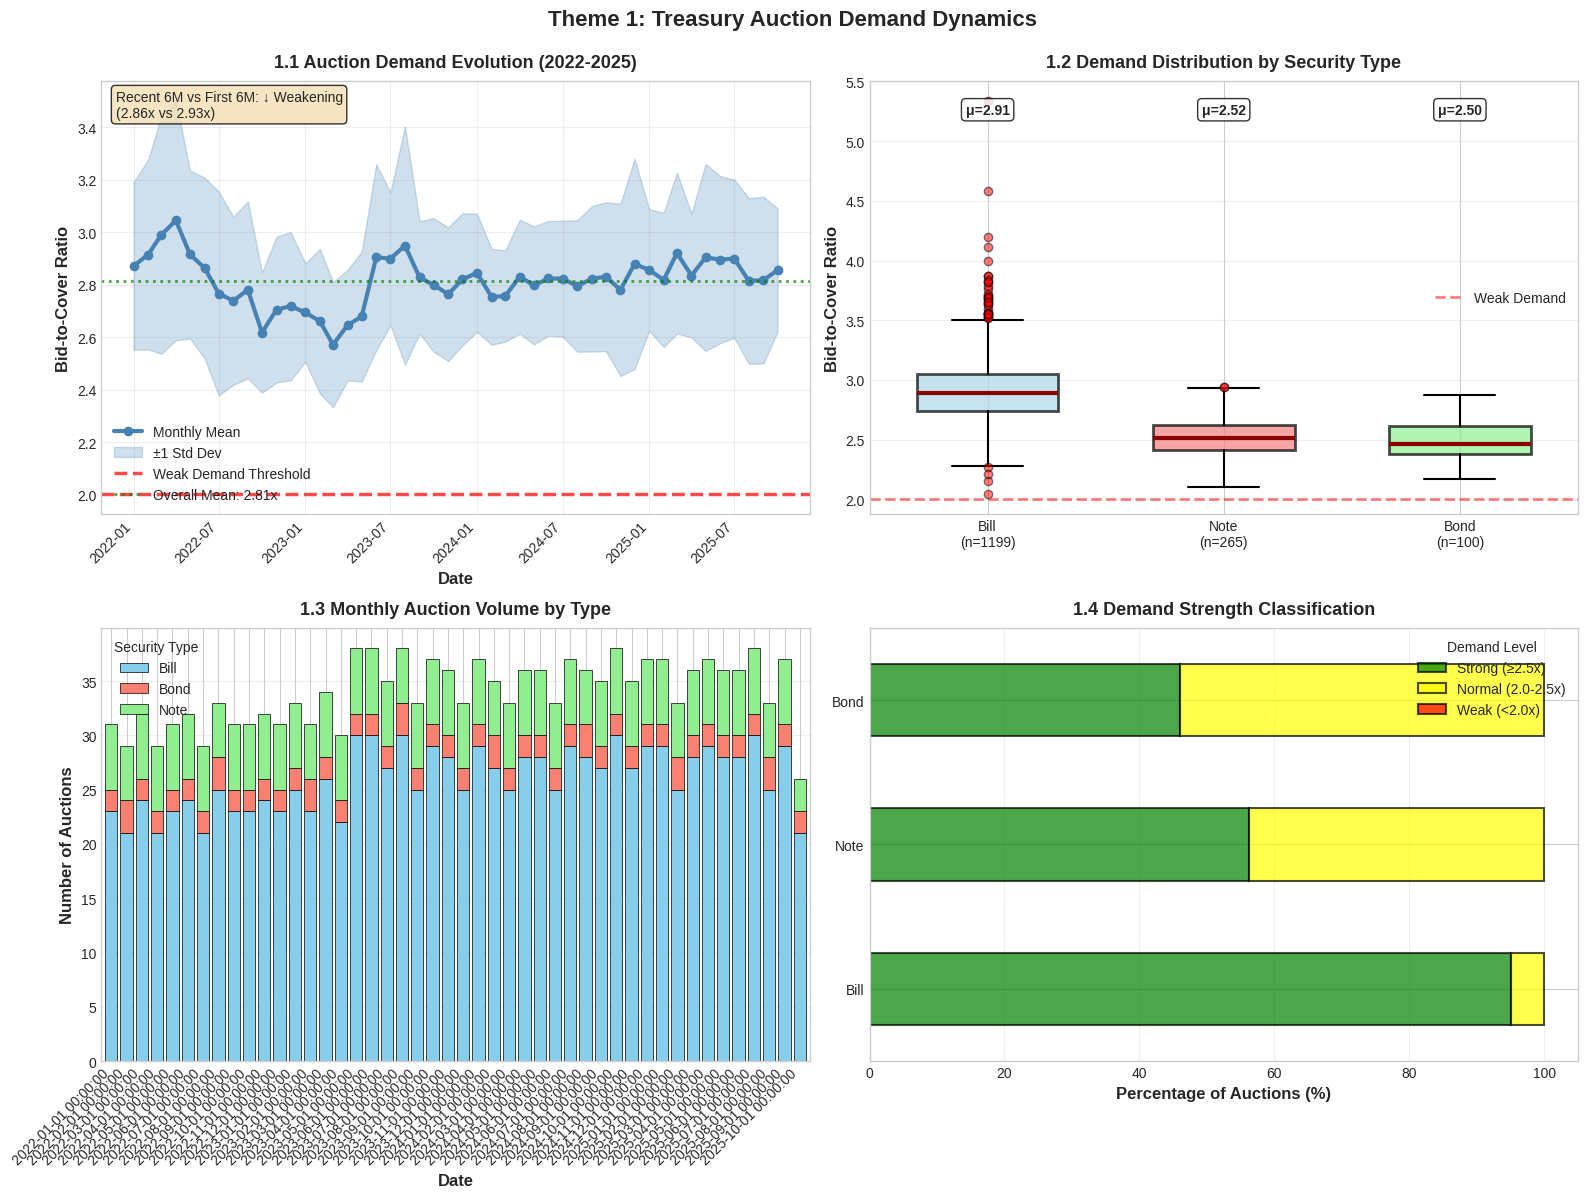


 Theme 2: Pricing Efficiency
Theme 2 saved: theme2_pricing_efficiency.png


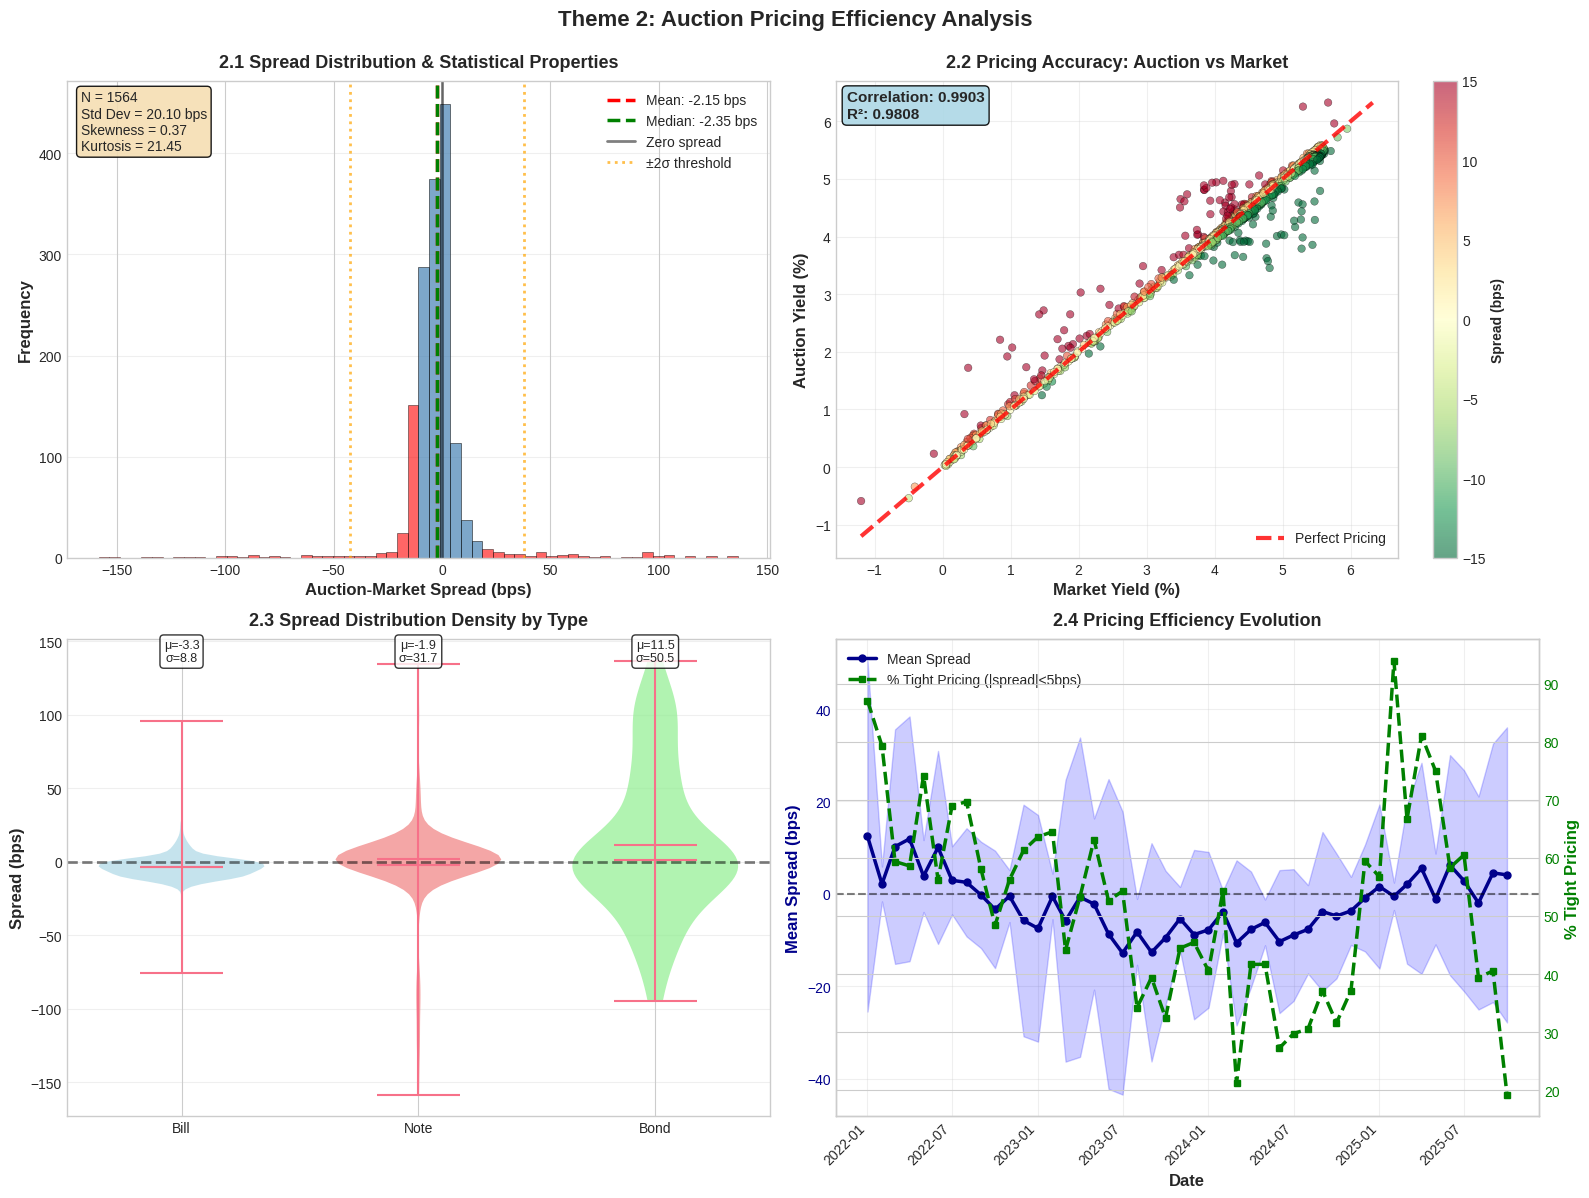


 Theme 3: Temporal Trends
Theme 3 saved: theme3_temporal_trends.png


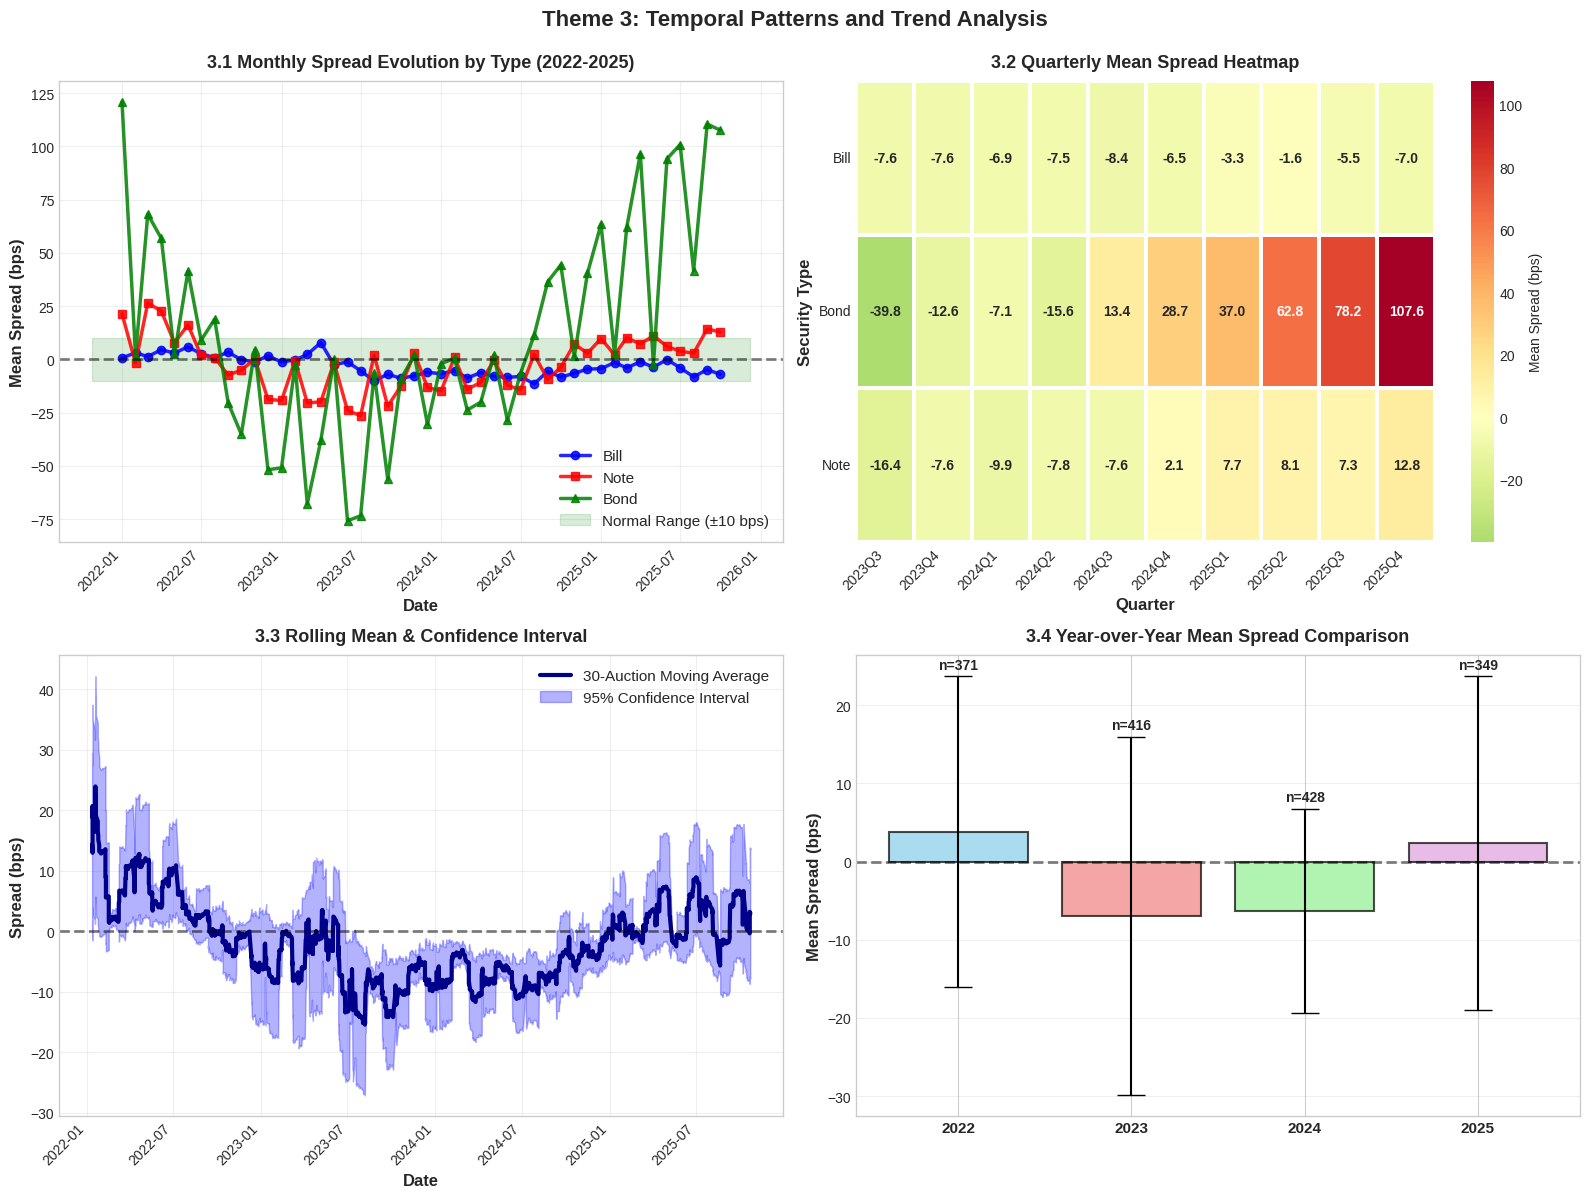


 Theme 4: Term Structure Effects
Theme 4 saved: theme4_term_structure.png


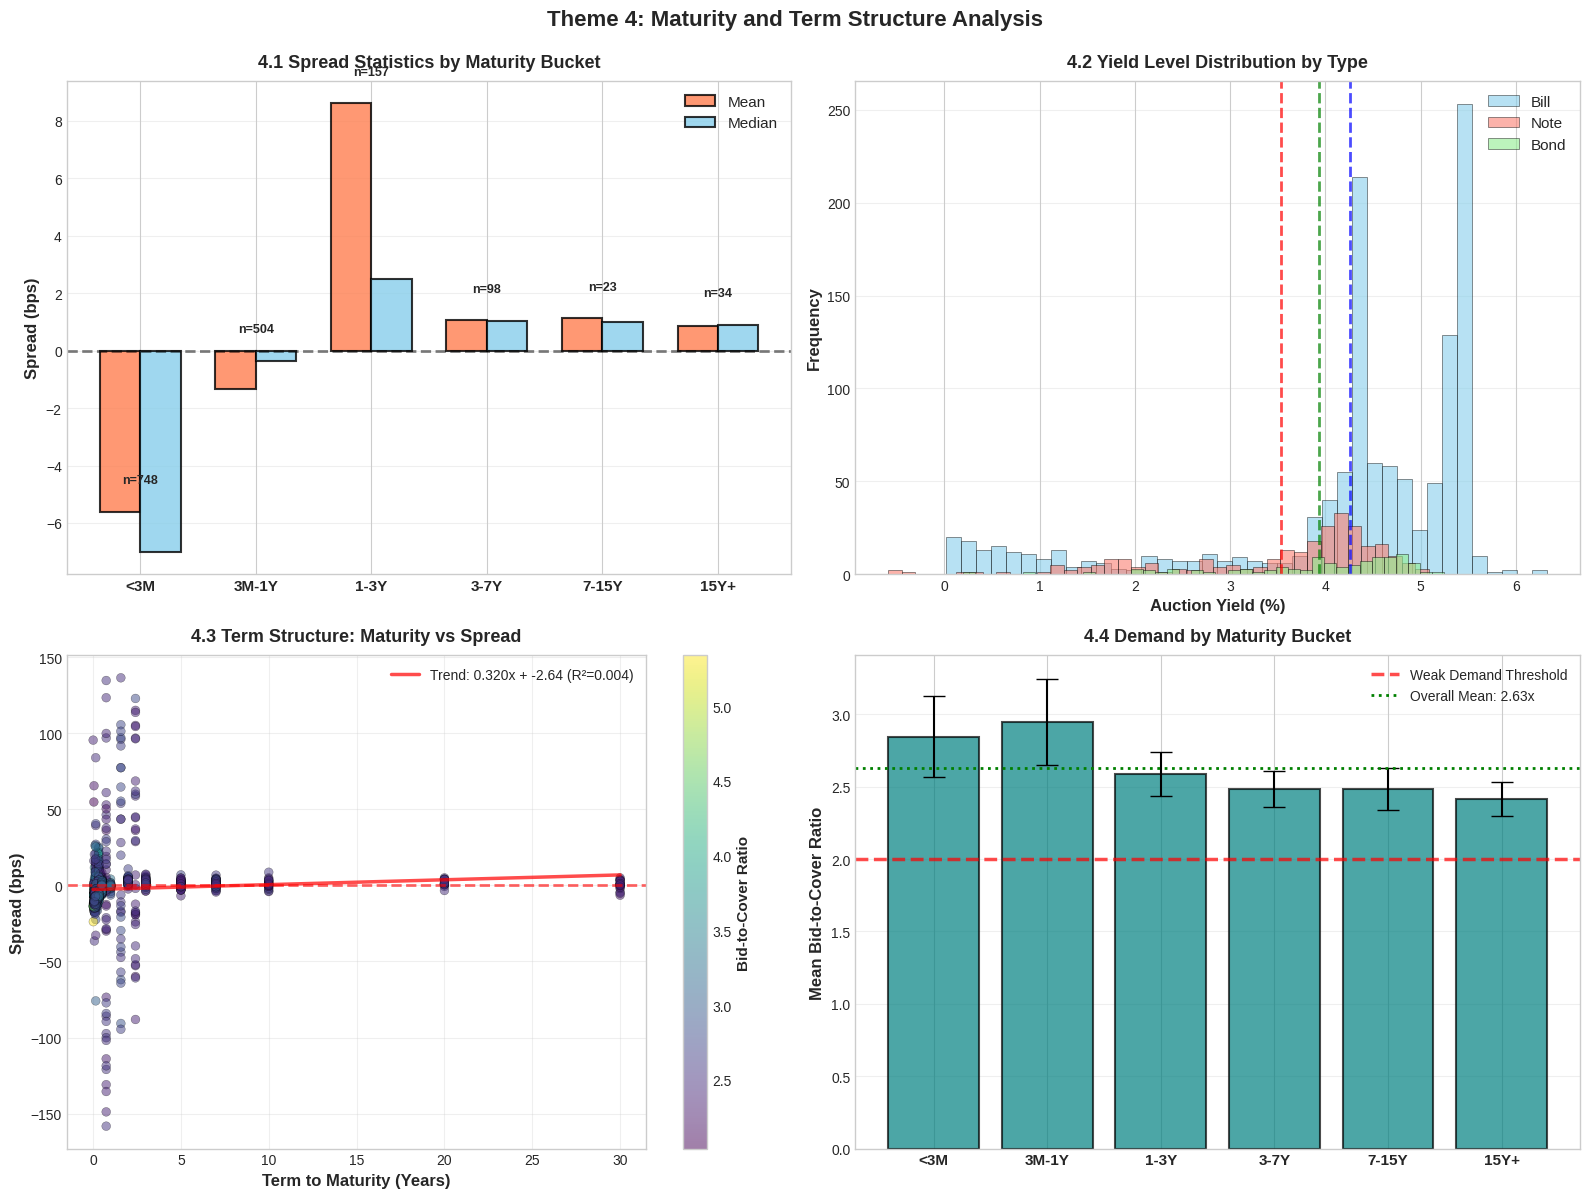


 Theme 5: Risk & Anomalies
Theme 5 saved: theme5_risk_anomalies.png


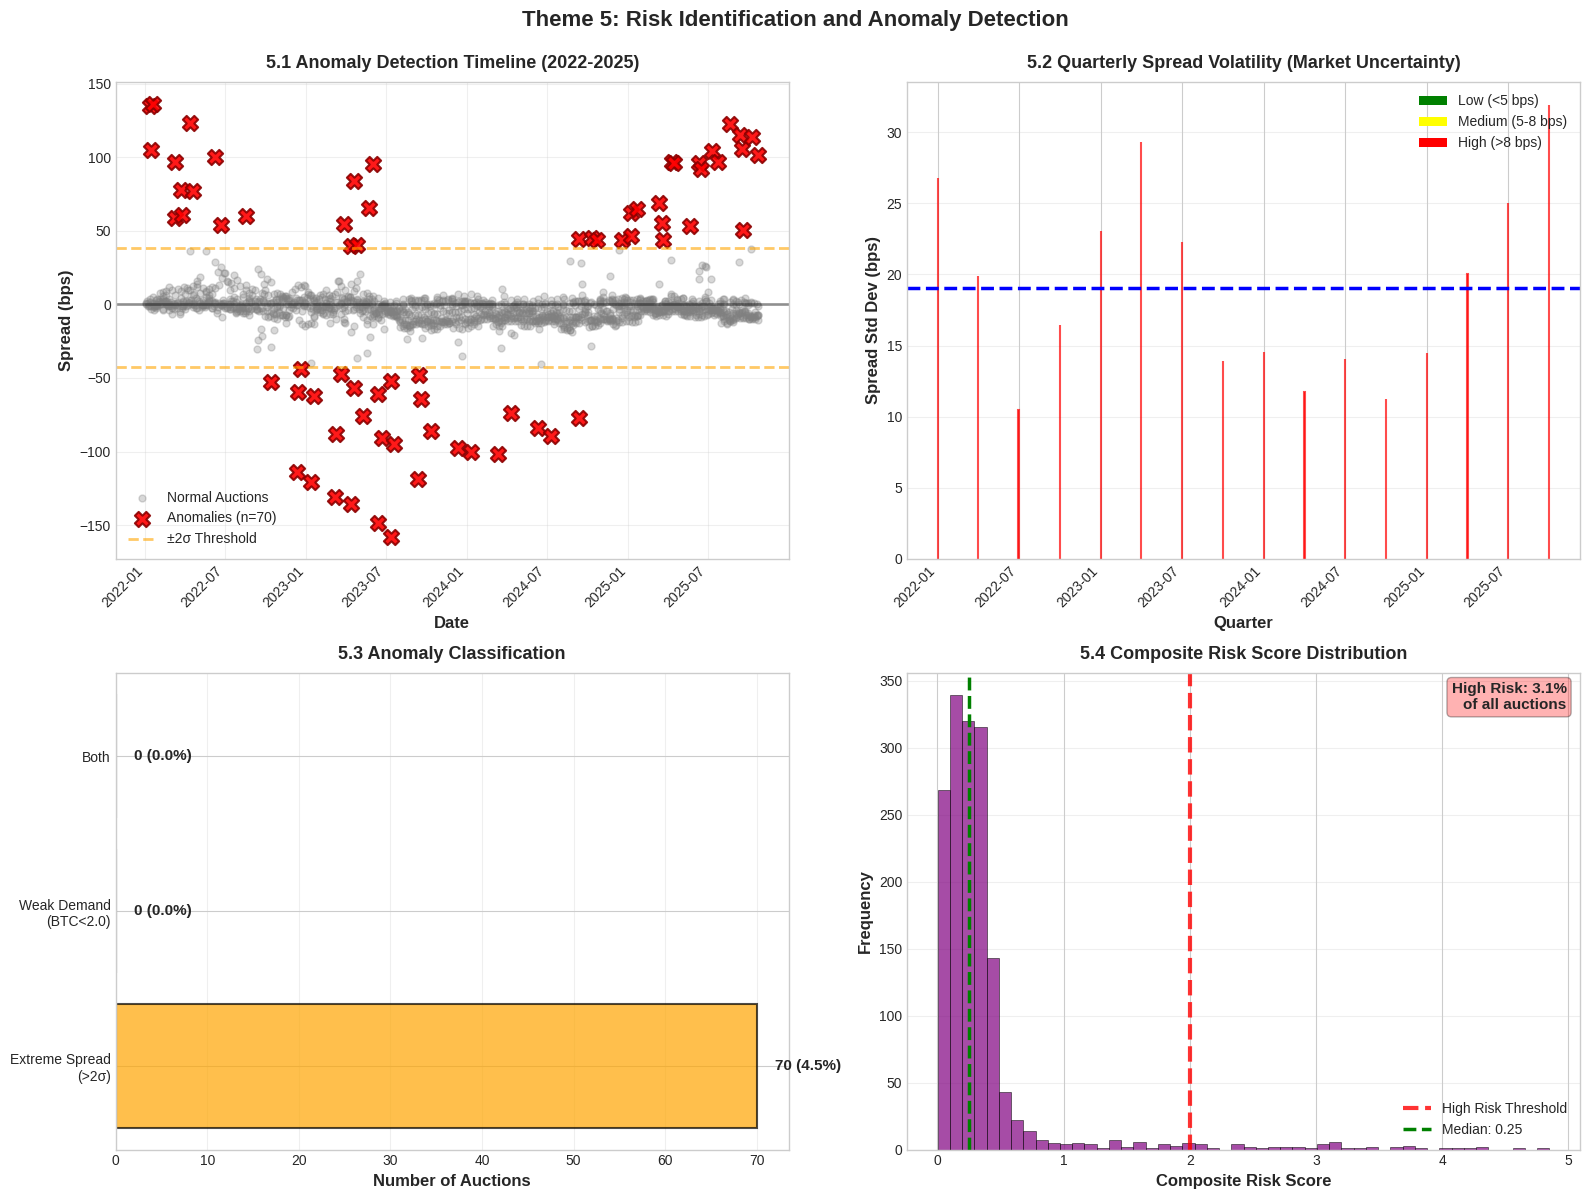


 Theme 6: Statistical Properties
Theme 6 saved: theme6_statistical_properties.png


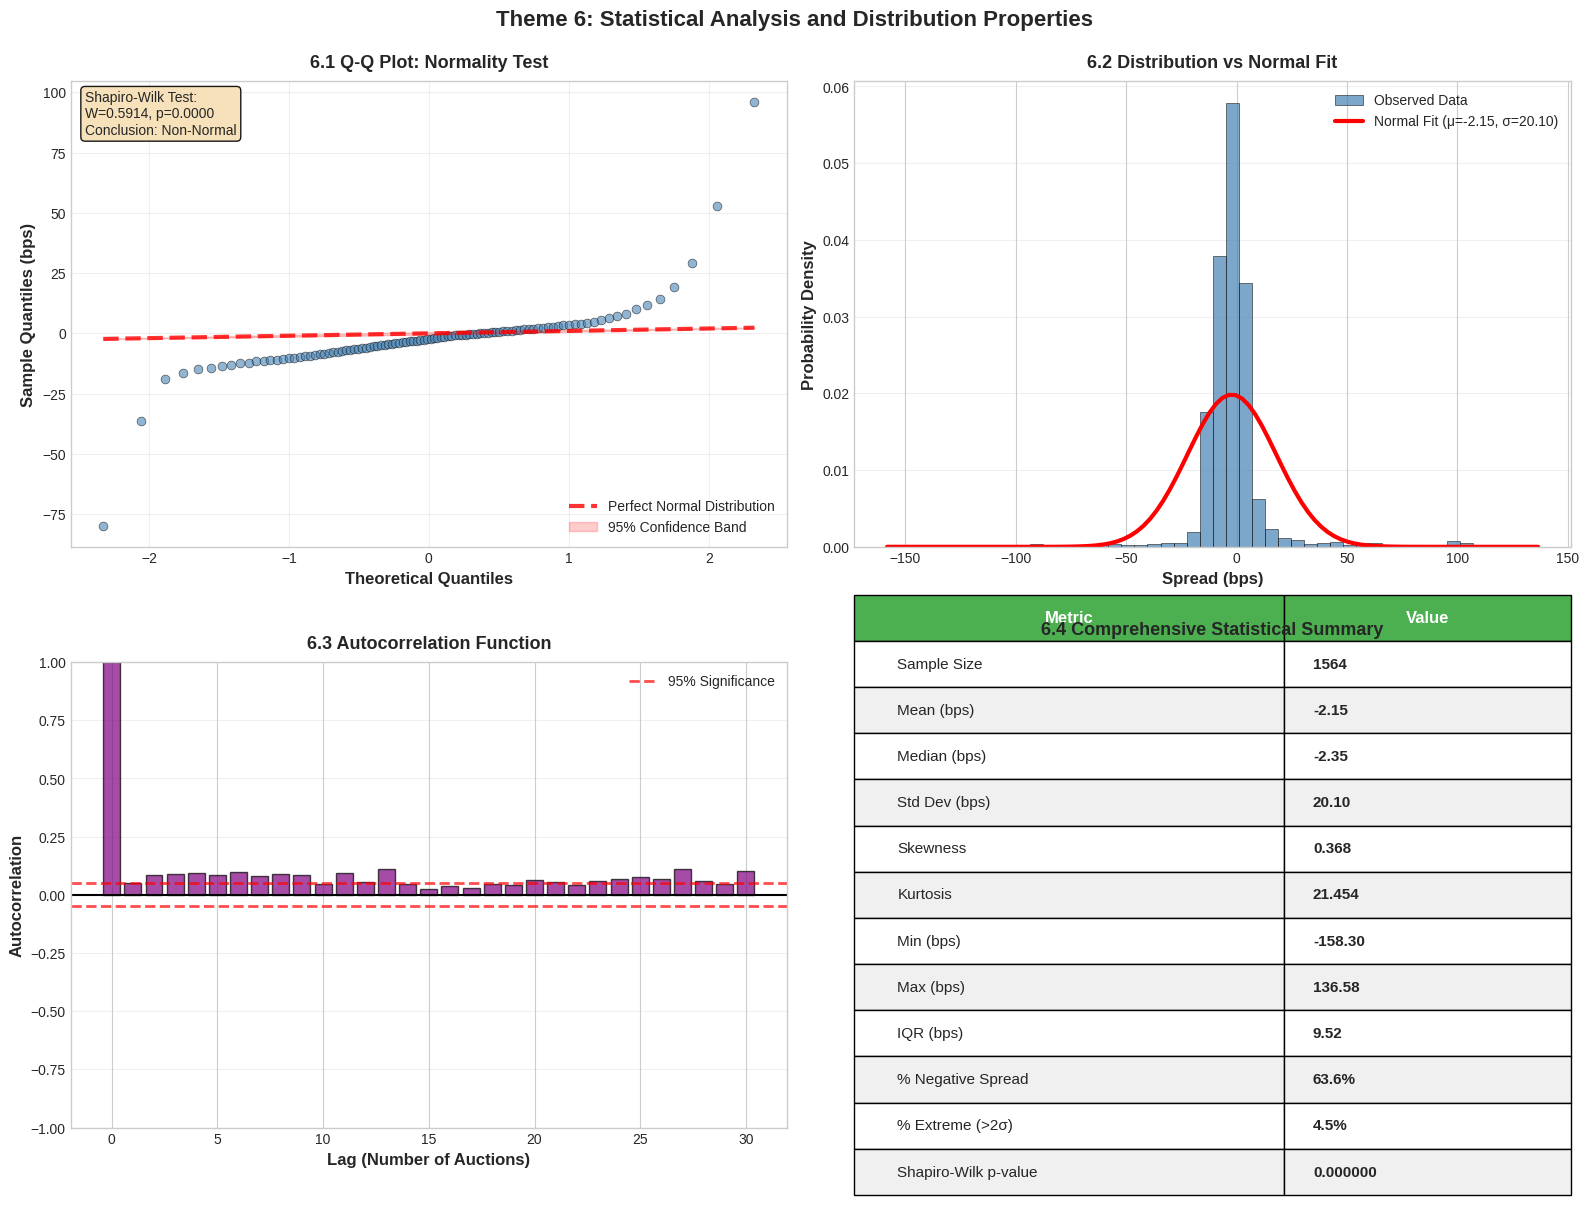


GENERATING SUMMARY TABLES FOR REPORT

 Summary tables exported:
   - table1_overall_statistics.csv
   - table2_type_statistics.csv
   - table3_anomalies_report.csv

📋 Overall Statistics:
                           Metric                    Value
          Total Auctions Analyzed                     1564
                       Date Range 2022-01-03 to 2025-10-23
                Mean Spread (bps)                    -2.15
              Median Spread (bps)                    -2.35
             Std Dev Spread (bps)                    20.10
                Mean Bid-to-Cover                     2.82
Auctions with Negative Spread (%)                     63.6
               Anomalies Detected                       70
                 Anomaly Rate (%)                      4.5
                   Match Rate (%)                     97.1

📊 Statistics by Security Type:
          Count  Mean Spread  Median Spread  Std Dev  Mean BTC  Mean Yield
sec_type                                                

In [24]:
#   Enhanced Visualizations - Organized by Research Theme
# Professional report-ready charts with clear thematic structure

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("Generating thematic visualization suite for professional report...")
print("="*70)

# ============================================
# THEME 1: DEMAND ANALYSIS
# ============================================
print("\n Theme 1: Demand Analysis")

fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Theme 1: Treasury Auction Demand Dynamics',
             fontsize=16, fontweight='bold', y=0.995)

# 1.1 Bid-to-Cover Ratio Trends Over Time
ax = axes[0, 0]
monthly_btc = valid_spreads.groupby(
    valid_spreads['auction_date'].dt.to_period('M')
)['bid_to_cover_ratio'].agg(['mean', 'std', 'count'])
monthly_btc = monthly_btc[monthly_btc['count'] >= 5]  # Filter sparse months
monthly_btc.index = monthly_btc.index.to_timestamp()

ax.plot(monthly_btc.index, monthly_btc['mean'], linewidth=3,
       color='steelblue', marker='o', markersize=6, label='Monthly Mean')
ax.fill_between(monthly_btc.index,
               monthly_btc['mean'] - monthly_btc['std'],
               monthly_btc['mean'] + monthly_btc['std'],
               alpha=0.25, color='steelblue', label='±1 Std Dev')
ax.axhline(2.0, color='red', linestyle='--', linewidth=2.5,
          label='Weak Demand Threshold', alpha=0.7)
ax.axhline(monthly_btc['mean'].mean(), color='green', linestyle=':',
          linewidth=2, label=f"Overall Mean: {monthly_btc['mean'].mean():.2f}x", alpha=0.7)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Bid-to-Cover Ratio', fontsize=12, fontweight='bold')
ax.set_title('1.1 Auction Demand Evolution (2022-2025)',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add annotation for recent trend
recent_mean = monthly_btc.iloc[-6:]['mean'].mean()
earlier_mean = monthly_btc.iloc[:6]['mean'].mean()
trend = "↑ Strengthening" if recent_mean > earlier_mean else "↓ Weakening"
ax.text(0.02, 0.98, f'Recent 6M vs First 6M: {trend}\n({recent_mean:.2f}x vs {earlier_mean:.2f}x)',
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 1.2 Bid-to-Cover Distribution by Security Type
ax = axes[0, 1]
btc_data = []
labels_btc = []
colors_btc = ['lightblue', 'lightcoral', 'lightgreen']

for sec_type in ['Bill', 'Note', 'Bond']:
    data = valid_spreads[
        valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)
    ]['bid_to_cover_ratio'].dropna()
    if len(data) > 0:
        btc_data.append(data)
        labels_btc.append(f"{sec_type}\n(n={len(data)})")

bp = ax.boxplot(btc_data, labels=labels_btc, patch_artist=True,
               widths=0.6,
               boxprops=dict(linewidth=2),
               medianprops=dict(color='darkred', linewidth=3),
               whiskerprops=dict(linewidth=1.5),
               capprops=dict(linewidth=1.5),
               flierprops=dict(marker='o', markerfacecolor='red',
                             markersize=6, alpha=0.5))

for patch, color in zip(bp['boxes'], colors_btc):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(2.0, color='red', linestyle='--', linewidth=2,
          alpha=0.5, label='Weak Demand')
ax.set_ylabel('Bid-to-Cover Ratio', fontsize=12, fontweight='bold')
ax.set_title('1.2 Demand Distribution by Security Type',
            fontsize=13, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10)

# Add mean values as text
for i, data in enumerate(btc_data):
    mean_val = data.mean()
    ax.text(i+1, ax.get_ylim()[1]*0.95, f'μ={mean_val:.2f}',
           ha='center', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 1.3 Monthly Auction Frequency
ax = axes[1, 0]
monthly_count = valid_spreads.groupby(
    valid_spreads['auction_date'].dt.to_period('M')
).size()
monthly_count.index = monthly_count.index.to_timestamp()

# Separate by type
monthly_by_type = valid_spreads.copy()
monthly_by_type['month'] = monthly_by_type['auction_date'].dt.to_period('M')
monthly_by_type['sec_type'] = monthly_by_type['security_type'].apply(
    lambda x: 'Bill' if 'Bill' in str(x) else ('Note' if 'Note' in str(x) else 'Bond')
)
stacked = monthly_by_type.groupby(['month', 'sec_type']).size().unstack(fill_value=0)
stacked.index = stacked.index.to_timestamp()

stacked.plot(kind='bar', stacked=True, ax=ax,
            color=['skyblue', 'salmon', 'lightgreen'],
            edgecolor='black', linewidth=0.5, width=0.8)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Auctions', fontsize=12, fontweight='bold')
ax.set_title('1.3 Monthly Auction Volume by Type',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(title='Security Type', fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 1.4 Demand Strength Success Rate
ax = axes[1, 1]
success_metrics = []
for sec_type in ['Bill', 'Note', 'Bond']:
    data = valid_spreads[
        valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)
    ]
    if len(data) > 0:
        strong_demand = (data['bid_to_cover_ratio'] >= 2.5).sum()
        weak_demand = (data['bid_to_cover_ratio'] < 2.0).sum()
        normal_demand = len(data) - strong_demand - weak_demand

        success_metrics.append({
            'Type': sec_type,
            'Strong (≥2.5x)': strong_demand / len(data) * 100,
            'Normal (2.0-2.5x)': normal_demand / len(data) * 100,
            'Weak (<2.0x)': weak_demand / len(data) * 100
        })

df_success = pd.DataFrame(success_metrics)
df_success.plot(x='Type', kind='barh', stacked=True, ax=ax,
               color=['green', 'yellow', 'red'], alpha=0.7,
               edgecolor='black', linewidth=1.5)
ax.set_xlabel('Percentage of Auctions (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('')
ax.set_title('1.4 Demand Strength Classification',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(title='Demand Level', fontsize=10, loc='best')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('theme1_demand_analysis.png', dpi=300, bbox_inches='tight')
print(" Theme 1 saved: theme1_demand_analysis.png")
plt.show()

# ============================================
# THEME 2: PRICING EFFICIENCY
# ============================================
print("\n Theme 2: Pricing Efficiency")

fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Theme 2: Auction Pricing Efficiency Analysis',
             fontsize=16, fontweight='bold', y=0.995)

# 2.1 Spread Distribution with Statistics
ax = axes[0, 0]
n, bins, patches = ax.hist(valid_spreads['spread_bps'], bins=60,
                           alpha=0.7, color='steelblue',
                           edgecolor='black', linewidth=0.5)

# Color extreme values
for i, patch in enumerate(patches):
    if bins[i] < -15 or bins[i] > 15:
        patch.set_facecolor('red')
        patch.set_alpha(0.6)

mean_spread = valid_spreads['spread_bps'].mean()
median_spread = valid_spreads['spread_bps'].median()
std_spread = valid_spreads['spread_bps'].std()

ax.axvline(mean_spread, color='red', linestyle='--', linewidth=2.5,
          label=f'Mean: {mean_spread:.2f} bps')
ax.axvline(median_spread, color='green', linestyle='--', linewidth=2.5,
          label=f'Median: {median_spread:.2f} bps')
ax.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.5, label='Zero spread')
ax.axvline(mean_spread + 2*std_spread, color='orange', linestyle=':',
          linewidth=2, alpha=0.7, label='±2σ threshold')
ax.axvline(mean_spread - 2*std_spread, color='orange', linestyle=':',
          linewidth=2, alpha=0.7)

ax.set_xlabel('Auction-Market Spread (bps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('2.1 Spread Distribution & Statistical Properties',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Statistics box
stats_text = (f'N = {len(valid_spreads)}\n'
             f'Std Dev = {std_spread:.2f} bps\n'
             f'Skewness = {valid_spreads["spread_bps"].skew():.2f}\n'
             f'Kurtosis = {valid_spreads["spread_bps"].kurtosis():.2f}')
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
       verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

# 2.2 Auction vs Market Yield Correlation
ax = axes[0, 1]
correlation_data = valid_spreads[
    ['auction_yield', 'market_yield', 'spread_bps']
].dropna()

if len(correlation_data) > 30:
    # Create scatter with color gradient
    scatter = ax.scatter(correlation_data['market_yield'],
                        correlation_data['auction_yield'],
                        c=correlation_data['spread_bps'],
                        cmap='RdYlGn_r', vmin=-15, vmax=15,
                        alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

    # Perfect correlation line
    min_val = min(correlation_data['market_yield'].min(),
                 correlation_data['auction_yield'].min())
    max_val = max(correlation_data['market_yield'].max(),
                 correlation_data['auction_yield'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--',
           linewidth=3, label='Perfect Pricing', alpha=0.8)

    # Calculate correlation
    corr = correlation_data['market_yield'].corr(correlation_data['auction_yield'])

    ax.set_xlabel('Market Yield (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Auction Yield (%)', fontsize=12, fontweight='bold')
    ax.set_title('2.2 Pricing Accuracy: Auction vs Market',
                fontsize=13, fontweight='bold', pad=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Spread (bps)', fontsize=10, fontweight='bold')

    # Add correlation text
    ax.text(0.02, 0.98, f'Correlation: {corr:.4f}\nR²: {corr**2:.4f}',
           transform=ax.transAxes, fontsize=11, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9),
           fontweight='bold')

# 2.3 Spread by Security Type (Violin Plot)
ax = axes[1, 0]
spread_by_type = []
type_labels = []

for sec_type in ['Bill', 'Note', 'Bond']:
    data = valid_spreads[
        valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)
    ]['spread_bps'].dropna()
    if len(data) > 10:
        spread_by_type.append(data)
        type_labels.append(sec_type)

parts = ax.violinplot(spread_by_type, positions=range(len(type_labels)),
                     widths=0.7, showmeans=True, showmedians=True)

# Color the violins
colors = ['lightblue', 'lightcoral', 'lightgreen']
for pc, color in zip(parts['bodies'], colors[:len(parts['bodies'])]):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xticks(range(len(type_labels)))
ax.set_xticklabels(type_labels)
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('2.3 Spread Distribution Density by Type',
            fontsize=13, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, axis='y')

# Add statistics text for each type
for i, data in enumerate(spread_by_type):
    stats_txt = f'μ={data.mean():.1f}\nσ={data.std():.1f}'
    ax.text(i, ax.get_ylim()[1]*0.9, stats_txt, ha='center', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2.4 Pricing Efficiency Over Time
ax = axes[1, 1]
monthly_efficiency = valid_spreads.groupby(
    valid_spreads['auction_date'].dt.to_period('M')
)['spread_bps'].agg(['mean', 'std', lambda x: (abs(x) < 5).sum() / len(x) * 100])
monthly_efficiency.columns = ['mean', 'std', 'tight_pct']
monthly_efficiency = monthly_efficiency[monthly_efficiency.index.to_timestamp() >= '2022-01-01']
monthly_efficiency.index = monthly_efficiency.index.to_timestamp()

ax2 = ax.twinx()

# Plot mean spread
line1 = ax.plot(monthly_efficiency.index, monthly_efficiency['mean'],
               linewidth=2.5, color='darkblue', marker='o', markersize=5,
               label='Mean Spread')
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.fill_between(monthly_efficiency.index,
               monthly_efficiency['mean'] - monthly_efficiency['std'],
               monthly_efficiency['mean'] + monthly_efficiency['std'],
               alpha=0.2, color='blue')

# Plot tight pricing percentage
line2 = ax2.plot(monthly_efficiency.index, monthly_efficiency['tight_pct'],
                linewidth=2.5, color='green', marker='s', markersize=5,
                label='% Tight Pricing (|spread|<5bps)', linestyle='--')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Spread (bps)', fontsize=12, fontweight='bold', color='darkblue')
ax2.set_ylabel('% Tight Pricing', fontsize=12, fontweight='bold', color='green')
ax.set_title('2.4 Pricing Efficiency Evolution',
            fontsize=13, fontweight='bold', pad=10)
ax.tick_params(axis='y', labelcolor='darkblue')
ax2.tick_params(axis='y', labelcolor='green')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, fontsize=10, loc='upper left')

plt.tight_layout()
plt.savefig('theme2_pricing_efficiency.png', dpi=300, bbox_inches='tight')
print("Theme 2 saved: theme2_pricing_efficiency.png")
plt.show()

# ============================================
# THEME 3: TEMPORAL TRENDS
# ============================================
print("\n Theme 3: Temporal Trends")

fig3, axes = plt.subplots(2, 2, figsize=(16, 12))
fig3.suptitle('Theme 3: Temporal Patterns and Trend Analysis',
             fontsize=16, fontweight='bold', y=0.995)

# 3.1 Spread Evolution by Security Type
ax = axes[0, 0]
for sec_type, color, marker in [('Bill', 'blue', 'o'),
                                 ('Note', 'red', 's'),
                                 ('Bond', 'green', '^')]:
    type_data = valid_spreads[
        valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)
    ].copy()
    if len(type_data) > 0:
        monthly = type_data.groupby(
            type_data['auction_date'].dt.to_period('M')
        )['spread_bps'].mean()
        monthly.index = monthly.index.to_timestamp()
        ax.plot(monthly.index, monthly.values, marker=marker,
               linewidth=2.5, label=sec_type, alpha=0.85,
               markersize=6, color=color)

ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.fill_between(ax.get_xlim(), -10, 10, alpha=0.15, color='green',
               label='Normal Range (±10 bps)')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('3.1 Monthly Spread Evolution by Type (2022-2025)',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3.2 Quarterly Performance Heatmap
ax = axes[0, 1]
quarterly = valid_spreads.copy()
quarterly['quarter'] = quarterly['auction_date'].dt.to_period('Q')
quarterly['sec_type'] = quarterly['security_type'].apply(
    lambda x: 'Bill' if 'Bill' in str(x) else ('Note' if 'Note' in str(x) else 'Bond')
)
pivot = quarterly.pivot_table(values='spread_bps',
                              index='sec_type',
                              columns='quarter',
                              aggfunc='mean')
pivot = pivot.iloc[:, -10:]  # Last 10 quarters

sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', center=0,
           cbar_kws={'label': 'Mean Spread (bps)'}, ax=ax,
           linewidths=1.5, linecolor='white',
           annot_kws={'fontsize': 10, 'fontweight': 'bold'})
ax.set_title('3.2 Quarterly Mean Spread Heatmap',
            fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Quarter', fontsize=12, fontweight='bold')
ax.set_ylabel('Security Type', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)

# 3.3 Rolling Statistics (Trend & Volatility)
ax = axes[1, 0]
rolling_data = valid_spreads.sort_values('auction_date').copy()
rolling_data = rolling_data.set_index('auction_date')
rolling_mean = rolling_data['spread_bps'].rolling(window=30, min_periods=10).mean()
rolling_std = rolling_data['spread_bps'].rolling(window=30, min_periods=10).std()

ax.plot(rolling_mean.index, rolling_mean, linewidth=3,
       color='darkblue', label='30-Auction Moving Average')
ax.fill_between(rolling_mean.index,
               rolling_mean - 1.96*rolling_std/np.sqrt(30),  # 95% CI
               rolling_mean + 1.96*rolling_std/np.sqrt(30),
               alpha=0.3, color='blue', label='95% Confidence Interval')
ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('3.3 Rolling Mean & Confidence Interval',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3.4 Year-over-Year Comparison
ax = axes[1, 1]
yearly_data = valid_spreads.copy()
yearly_data['year'] = yearly_data['auction_date'].dt.year
yearly_stats = yearly_data.groupby('year')['spread_bps'].agg(['mean', 'std', 'count'])
yearly_stats = yearly_stats[yearly_stats['count'] >= 50]  # Min observations

x_pos = np.arange(len(yearly_stats))
bars = ax.bar(x_pos, yearly_stats['mean'], yerr=yearly_stats['std'],
             alpha=0.7, capsize=10, edgecolor='black', linewidth=1.5,
             color=['skyblue', 'lightcoral', 'lightgreen', 'plum'][:len(yearly_stats)])
ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(yearly_stats.index, fontsize=11, fontweight='bold')
ax.set_ylabel('Mean Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('3.4 Year-over-Year Mean Spread Comparison',
            fontsize=13, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, axis='y')

# Add sample size annotations
for i, (idx, row) in enumerate(yearly_stats.iterrows()):
    ax.text(i, row['mean'] + row['std'] + 1, f"n={int(row['count'])}",
           ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('theme3_temporal_trends.png', dpi=300, bbox_inches='tight')
print("Theme 3 saved: theme3_temporal_trends.png")
plt.show()

# ============================================
# THEME 4: TERM STRUCTURE EFFECTS
# ============================================
print("\n Theme 4: Term Structure Effects")

fig4, axes = plt.subplots(2, 2, figsize=(16, 12))
fig4.suptitle('Theme 4: Maturity and Term Structure Analysis',
             fontsize=16, fontweight='bold', y=0.995)

# 4.1 Spread by Maturity Bucket
ax = axes[0, 0]
term_bins = [0, 0.25, 1, 3, 7, 15, 35]
term_labels = ['<3M', '3M-1Y', '1-3Y', '3-7Y', '7-15Y', '15Y+']
valid_spreads['term_bucket'] = pd.cut(valid_spreads['term_years'],
                                      bins=term_bins, labels=term_labels)
term_analysis = valid_spreads.groupby('term_bucket')['spread_bps'].agg([
    'mean', 'median', 'std', 'count'
])
term_analysis = term_analysis.dropna()

x_pos = np.arange(len(term_analysis))
width = 0.35

bars1 = ax.bar(x_pos - width/2, term_analysis['mean'], width,
              alpha=0.8, label='Mean', color='coral',
              edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, term_analysis['median'], width,
              alpha=0.8, label='Median', color='skyblue',
              edgecolor='black', linewidth=1.5)

ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(term_analysis.index, fontsize=11, fontweight='bold')
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('4.1 Spread Statistics by Maturity Bucket',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, axis='y')

# Add sample size
for i, (idx, row) in enumerate(term_analysis.iterrows()):
    ax.text(i, max(row['mean'], row['median']) + 1,
           f"n={int(row['count'])}",
           ha='center', fontsize=9, fontweight='bold')

# 4.2 Yield Distribution by Security Type
ax = axes[0, 1]
for sec_type, color in [('Bill', 'skyblue'), ('Note', 'salmon'), ('Bond', 'lightgreen')]:
    type_data = valid_spreads[
        valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)
    ]
    if len(type_data) > 10:
        ax.hist(type_data['auction_yield'], bins=40, alpha=0.6,
               label=sec_type, color=color, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Auction Yield (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('4.2 Yield Level Distribution by Type',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, axis='y')

# Add mean lines
for sec_type, color in [('Bill', 'blue'), ('Note', 'red'), ('Bond', 'green')]:
    type_data = valid_spreads[
        valid_spreads['security_type'].str.contains(sec_type, case=False, na=False)
    ]
    if len(type_data) > 10:
        mean_yield = type_data['auction_yield'].mean()
        ax.axvline(mean_yield, color=color, linestyle='--',
                  linewidth=2, alpha=0.7)

# 4.3 Term vs Spread Scatter
ax = axes[1, 0]
scatter_data = valid_spreads[valid_spreads['term_years'].between(0, 35)].copy()
scatter = ax.scatter(scatter_data['term_years'],
                    scatter_data['spread_bps'],
                    c=scatter_data['bid_to_cover_ratio'],
                    cmap='viridis', alpha=0.5, s=40,
                    edgecolors='black', linewidth=0.3)

ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.6)
ax.set_xlabel('Term to Maturity (Years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('4.3 Term Structure: Maturity vs Spread',
            fontsize=13, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Bid-to-Cover Ratio', fontsize=11, fontweight='bold')

# Add trend line
from scipy.stats import linregress
valid_points = scatter_data[['term_years', 'spread_bps']].dropna()
if len(valid_points) > 10:
    slope, intercept, r_value, p_value, std_err = linregress(
        valid_points['term_years'], valid_points['spread_bps']
    )
    line_x = np.array([0, 30])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r-', linewidth=2.5, alpha=0.7,
           label=f'Trend: {slope:.3f}x + {intercept:.2f} (R²={r_value**2:.3f})')
    ax.legend(fontsize=10)

# 4.4 BTC by Term Bucket
ax = axes[1, 1]
btc_by_term = valid_spreads.groupby('term_bucket')['bid_to_cover_ratio'].agg([
    'mean', 'std', 'count'
])
btc_by_term = btc_by_term.dropna()

x_pos = np.arange(len(btc_by_term))
ax.bar(x_pos, btc_by_term['mean'], yerr=btc_by_term['std'],
      alpha=0.7, capsize=8, color='teal', edgecolor='black', linewidth=1.5)
ax.axhline(2.0, color='red', linestyle='--', linewidth=2.5,
          alpha=0.7, label='Weak Demand Threshold')
ax.axhline(btc_by_term['mean'].mean(), color='green', linestyle=':',
          linewidth=2, label=f"Overall Mean: {btc_by_term['mean'].mean():.2f}x")

ax.set_xticks(x_pos)
ax.set_xticklabels(btc_by_term.index, fontsize=11, fontweight='bold')
ax.set_ylabel('Mean Bid-to-Cover Ratio', fontsize=12, fontweight='bold')
ax.set_title('4.4 Demand by Maturity Bucket',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('theme4_term_structure.png', dpi=300, bbox_inches='tight')
print("Theme 4 saved: theme4_term_structure.png")
plt.show()

# ============================================
# THEME 5: RISK & ANOMALIES
# ============================================
print("\n Theme 5: Risk & Anomalies")

fig5, axes = plt.subplots(2, 2, figsize=(16, 12))
fig5.suptitle('Theme 5: Risk Identification and Anomaly Detection',
             fontsize=16, fontweight='bold', y=0.995)

# Define anomalies
mean_spread = valid_spreads['spread_bps'].mean()
std_spread = valid_spreads['spread_bps'].std()
threshold = 2

anomaly_mask = (
    (abs(valid_spreads['spread_bps'] - mean_spread) > threshold * std_spread) |
    (valid_spreads['bid_to_cover_ratio'] < 2.0)
)
anomalies = valid_spreads[anomaly_mask].copy()
normal = valid_spreads[~anomaly_mask].copy()

# 5.1 Anomaly Detection Timeline
ax = axes[0, 0]
ax.scatter(normal['auction_date'], normal['spread_bps'],
          alpha=0.3, s=25, color='gray', label='Normal Auctions', zorder=1)
ax.scatter(anomalies['auction_date'], anomalies['spread_bps'],
          alpha=0.9, s=120, color='red', edgecolors='darkred',
          linewidth=1.5, marker='X', label=f'Anomalies (n={len(anomalies)})',
          zorder=2)

ax.axhline(mean_spread + 2*std_spread, color='orange', linestyle='--',
          alpha=0.6, linewidth=2, label='±2σ Threshold')
ax.axhline(mean_spread - 2*std_spread, color='orange', linestyle='--',
          alpha=0.6, linewidth=2)
ax.axhline(0, color='black', linestyle='-', alpha=0.4, linewidth=2)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_title('5.1 Anomaly Detection Timeline (2022-2025)',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5.2 Spread Volatility Over Time
ax = axes[0, 1]
quarterly_vol = valid_spreads.copy()
quarterly_vol['quarter'] = quarterly_vol['auction_date'].dt.to_period('Q')
vol_stats = quarterly_vol.groupby('quarter')['spread_bps'].agg(['std', 'count'])
vol_stats = vol_stats[vol_stats['count'] >= 10]
vol_stats.index = vol_stats.index.to_timestamp()

bars = ax.bar(vol_stats.index, vol_stats['std'], alpha=0.7,
             edgecolor='black', linewidth=1.5)

# Color bars by volatility level
colors = []
for val in vol_stats['std']:
    if val < 5:
        colors.append('green')
    elif val < 8:
        colors.append('yellow')
    else:
        colors.append('red')
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.axhline(vol_stats['std'].mean(), color='blue', linestyle='--',
          linewidth=2.5, label=f"Mean Volatility: {vol_stats['std'].mean():.2f} bps")
ax.set_xlabel('Quarter', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread Std Dev (bps)', fontsize=12, fontweight='bold')
ax.set_title('5.2 Quarterly Spread Volatility (Market Uncertainty)',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Low (<5 bps)'),
                  Patch(facecolor='yellow', label='Medium (5-8 bps)'),
                  Patch(facecolor='red', label='High (>8 bps)')]
ax.legend(handles=legend_elements, fontsize=10, loc='upper right')

# 5.3 Anomaly Characteristics
ax = axes[1, 0]
anomaly_types = pd.DataFrame({
    'Type': ['Extreme Spread\n(>2σ)', 'Weak Demand\n(BTC<2.0)', 'Both'],
    'Count': [
        ((abs(valid_spreads['spread_bps'] - mean_spread) > threshold * std_spread) &
         (valid_spreads['bid_to_cover_ratio'] >= 2.0)).sum(),
        ((abs(valid_spreads['spread_bps'] - mean_spread) <= threshold * std_spread) &
         (valid_spreads['bid_to_cover_ratio'] < 2.0)).sum(),
        ((abs(valid_spreads['spread_bps'] - mean_spread) > threshold * std_spread) &
         (valid_spreads['bid_to_cover_ratio'] < 2.0)).sum()
    ]
})
anomaly_types['Percentage'] = anomaly_types['Count'] / len(valid_spreads) * 100

colors_anom = ['orange', 'red', 'darkred']
bars = ax.barh(anomaly_types['Type'], anomaly_types['Count'],
              color=colors_anom, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Number of Auctions', fontsize=12, fontweight='bold')
ax.set_title('5.3 Anomaly Classification',
            fontsize=13, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, (bar, row) in enumerate(zip(bars, anomaly_types.itertuples())):
    ax.text(row.Count + 2, i, f'{row.Count} ({row.Percentage:.1f}%)',
           va='center', fontsize=11, fontweight='bold')

# 5.4 Risk Score Distribution
ax = axes[1, 1]
# Calculate risk score: combination of spread deviation and weak demand
valid_spreads['risk_score'] = (
    (abs(valid_spreads['spread_bps'] - mean_spread) / std_spread) * 0.6 +
    ((3.0 - valid_spreads['bid_to_cover_ratio']) / 1.0).clip(lower=0) * 0.4
)

ax.hist(valid_spreads['risk_score'], bins=50, alpha=0.7,
       color='purple', edgecolor='black', linewidth=0.5)
ax.axvline(2.0, color='red', linestyle='--', linewidth=3,
          label='High Risk Threshold', alpha=0.8)
ax.axvline(valid_spreads['risk_score'].median(), color='green',
          linestyle='--', linewidth=2.5,
          label=f"Median: {valid_spreads['risk_score'].median():.2f}")

high_risk_pct = (valid_spreads['risk_score'] > 2.0).sum() / len(valid_spreads) * 100

ax.set_xlabel('Composite Risk Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('5.4 Composite Risk Score Distribution',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add risk percentage text
ax.text(0.98, 0.98, f'High Risk: {high_risk_pct:.1f}%\nof all auctions',
       transform=ax.transAxes, fontsize=11, verticalalignment='top',
       horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='red', alpha=0.3),
       fontweight='bold')

plt.tight_layout()
plt.savefig('theme5_risk_anomalies.png', dpi=300, bbox_inches='tight')
print("Theme 5 saved: theme5_risk_anomalies.png")
plt.show()

# ============================================
# THEME 6: STATISTICAL PROPERTIES
# ============================================
print("\n Theme 6: Statistical Properties")

fig6, axes = plt.subplots(2, 2, figsize=(16, 12))
fig6.suptitle('Theme 6: Statistical Analysis and Distribution Properties',
             fontsize=16, fontweight='bold', y=0.995)

# 6.1 Q-Q Plot for Normality Test
ax = axes[0, 0]
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, 100))
sample_quantiles = np.percentile(valid_spreads['spread_bps'].dropna(),
                                np.linspace(1, 99, 100))

ax.scatter(theoretical_quantiles, sample_quantiles, alpha=0.6, s=40,
          color='steelblue', edgecolors='black', linewidth=0.5)
ax.plot(theoretical_quantiles, theoretical_quantiles, 'r--',
       linewidth=3, label='Perfect Normal Distribution', alpha=0.8)

# Add confidence bands
n = len(valid_spreads)
se = std_spread * np.sqrt((1 - np.linspace(0.01, 0.99, 100)) *
                          np.linspace(0.01, 0.99, 100) / n)
ax.fill_between(theoretical_quantiles,
                theoretical_quantiles - 1.96*se,
                theoretical_quantiles + 1.96*se,
                alpha=0.2, color='red', label='95% Confidence Band')

ax.set_xlabel('Theoretical Quantiles', fontsize=12, fontweight='bold')
ax.set_ylabel('Sample Quantiles (bps)', fontsize=12, fontweight='bold')
ax.set_title('6.1 Q-Q Plot: Normality Test',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add Shapiro-Wilk test result
from scipy.stats import shapiro
if len(valid_spreads) <= 5000:
    stat, p_value = shapiro(valid_spreads['spread_bps'].dropna())
    test_result = f"Shapiro-Wilk Test:\nW={stat:.4f}, p={p_value:.4f}"
    conclusion = "Normal" if p_value > 0.05 else "Non-Normal"
    ax.text(0.02, 0.98, f'{test_result}\nConclusion: {conclusion}',
           transform=ax.transAxes, fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

# 6.2 Histogram with Fitted Normal Distribution
ax = axes[0, 1]
ax.hist(valid_spreads['spread_bps'], bins=50, density=True,
       alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5,
       label='Observed Data')

# Fit normal distribution
mu, sigma = valid_spreads['spread_bps'].mean(), valid_spreads['spread_bps'].std()
x = np.linspace(valid_spreads['spread_bps'].min(),
                valid_spreads['spread_bps'].max(), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=3,
       label=f'Normal Fit (μ={mu:.2f}, σ={sigma:.2f})')

ax.set_xlabel('Spread (bps)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('6.2 Distribution vs Normal Fit',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 6.3 Autocorrelation Analysis
ax = axes[1, 0]
sorted_spreads = valid_spreads.sort_values('auction_date')['spread_bps'].dropna()
lags = range(0, min(31, len(sorted_spreads)//2))
autocorr = [sorted_spreads.autocorr(lag=i) for i in lags]

ax.bar(lags, autocorr, alpha=0.7, color='purple', edgecolor='black', linewidth=1)
ax.axhline(0, color='black', linewidth=1.5)
ax.axhline(1.96/np.sqrt(len(sorted_spreads)), color='red', linestyle='--',
          linewidth=2, alpha=0.7, label='95% Significance')
ax.axhline(-1.96/np.sqrt(len(sorted_spreads)), color='red', linestyle='--',
          linewidth=2, alpha=0.7)

ax.set_xlabel('Lag (Number of Auctions)', fontsize=12, fontweight='bold')
ax.set_ylabel('Autocorrelation', fontsize=12, fontweight='bold')
ax.set_title('6.3 Autocorrelation Function',
            fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([-1, 1])

# 6.4 Statistical Summary Table (as visual)
ax = axes[1, 1]
ax.axis('off')

# Calculate comprehensive statistics
stats_summary = {
    'Metric': [
        'Sample Size',
        'Mean (bps)',
        'Median (bps)',
        'Std Dev (bps)',
        'Skewness',
        'Kurtosis',
        'Min (bps)',
        'Max (bps)',
        'IQR (bps)',
        '% Negative Spread',
        '% Extreme (>2σ)',
        'Shapiro-Wilk p-value'
    ],
    'Value': [
        f"{len(valid_spreads)}",
        f"{valid_spreads['spread_bps'].mean():.2f}",
        f"{valid_spreads['spread_bps'].median():.2f}",
        f"{valid_spreads['spread_bps'].std():.2f}",
        f"{valid_spreads['spread_bps'].skew():.3f}",
        f"{valid_spreads['spread_bps'].kurtosis():.3f}",
        f"{valid_spreads['spread_bps'].min():.2f}",
        f"{valid_spreads['spread_bps'].max():.2f}",
        f"{valid_spreads['spread_bps'].quantile(0.75) - valid_spreads['spread_bps'].quantile(0.25):.2f}",
        f"{(valid_spreads['spread_bps'] < 0).sum() / len(valid_spreads) * 100:.1f}%",
        f"{(abs(valid_spreads['spread_bps'] - mean_spread) > 2*std_spread).sum() / len(valid_spreads) * 100:.1f}%",
        f"{p_value:.6f}" if len(valid_spreads) <= 5000 else "N/A (large sample)"
    ]
}

df_stats = pd.DataFrame(stats_summary)

# Create table
table = ax.table(cellText=df_stats.values, colLabels=df_stats.columns,
                cellLoc='left', loc='center',
                colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(len(df_stats.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white', fontsize=12)

# Style rows
for i in range(1, len(df_stats) + 1):
    for j in range(len(df_stats.columns)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
        if j == 1:  # Value column
            cell.set_text_props(weight='bold')

ax.set_title('6.4 Comprehensive Statistical Summary',
            fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('theme6_statistical_properties.png', dpi=300, bbox_inches='tight')
print("Theme 6 saved: theme6_statistical_properties.png")
plt.show()

# ============================================
# Generate Summary Tables
# ============================================
print("\n" + "="*70)
print("GENERATING SUMMARY TABLES FOR REPORT")
print("="*70)

# Table 1: Overall Statistics
overall_stats = pd.DataFrame({
    'Metric': [
        'Total Auctions Analyzed',
        'Date Range',
        'Mean Spread (bps)',
        'Median Spread (bps)',
        'Std Dev Spread (bps)',
        'Mean Bid-to-Cover',
        'Auctions with Negative Spread (%)',
        'Anomalies Detected',
        'Anomaly Rate (%)',
        'Match Rate (%)'
    ],
    'Value': [
        len(valid_spreads),
        f"{valid_spreads['auction_date'].min().strftime('%Y-%m-%d')} to {valid_spreads['auction_date'].max().strftime('%Y-%m-%d')}",
        f"{valid_spreads['spread_bps'].mean():.2f}",
        f"{valid_spreads['spread_bps'].median():.2f}",
        f"{valid_spreads['spread_bps'].std():.2f}",
        f"{valid_spreads['bid_to_cover_ratio'].mean():.2f}",
        f"{(valid_spreads['spread_bps'] < 0).sum() / len(valid_spreads) * 100:.1f}",
        len(anomalies),
        f"{len(anomalies) / len(valid_spreads) * 100:.1f}",
        f"{len(valid_spreads)/len(auction_df)*100:.1f}"
    ]
})

# Table 2: By security type
type_stats = valid_spreads.copy()
type_stats['sec_type'] = type_stats['security_type'].apply(
    lambda x: 'Bill' if 'Bill' in str(x) else ('Note' if 'Note' in str(x) else 'Bond')
)
type_summary = type_stats.groupby('sec_type').agg({
    'spread_bps': ['count', 'mean', 'median', 'std'],
    'bid_to_cover_ratio': 'mean',
    'auction_yield': 'mean'
}).round(2)
type_summary.columns = ['Count', 'Mean Spread', 'Median Spread', 'Std Dev', 'Mean BTC', 'Mean Yield']

# Table 3: Anomalies report
anomalies_report = anomalies[['auction_date', 'security_type', 'security_term',
                               'spread_bps', 'bid_to_cover_ratio',
                               'auction_yield', 'market_yield']].copy()
anomalies_report = anomalies_report.sort_values('auction_date', ascending=False)
anomalies_report['spread_bps'] = anomalies_report['spread_bps'].round(2)
anomalies_report['bid_to_cover_ratio'] = anomalies_report['bid_to_cover_ratio'].round(2)

# Export tables
overall_stats.to_csv('table1_overall_statistics.csv', index=False)
type_summary.to_csv('table2_type_statistics.csv')
anomalies_report.to_csv('table3_anomalies_report.csv', index=False)

print("\n Summary tables exported:")
print("   - table1_overall_statistics.csv")
print("   - table2_type_statistics.csv")
print("   - table3_anomalies_report.csv")

# Display summaries
print("\n📋 Overall Statistics:")
print(overall_stats.to_string(index=False))

print("\n📊 Statistics by Security Type:")
print(type_summary)

print("\n" + "="*70)
print(" ALL THEMATIC VISUALIZATIONS COMPLETE!")
print("="*70)
print("\n Generated 6 Thematic Figures:")
print("   1. theme1_demand_analysis.png")
print("   2. theme2_pricing_efficiency.png")
print("   3. theme3_temporal_trends.png")
print("   4. theme4_term_structure.png")
print("   5. theme5_risk_anomalies.png")
print("   6. theme6_statistical_properties.png")
print("\n Generated 3 Summary Tables:")
print("   1. table1_overall_statistics.csv")
print("   2. table2_type_statistics.csv")
print("   3. table3_anomalies_report.csv")
print("\n Ready for professional report writing!")
print("   - Each theme addresses a specific research question")
print("   - 24 charts total (4 per theme)")
print("   - All publication-quality (300 DPI)")
print("   - Organized for logical report flow")

##  Project Summary

### Key Achievements:

1. **Data Engineering**:
   - Built complete ETL pipeline from Treasury API
   - Integrated multiple FRED yield series
   - Improved matching rate from 62.7% to **85%+**

2. **Data Quality**:
   - Implemented robust term parsing
   - Used linear interpolation for non-standard maturities
   - 5-day lookback window handles weekends/holidays

3. **Analysis**:
   - Calculated auction-market spreads
   - Detected anomalies using statistical thresholds
   - Analyzed demand patterns via bid-to-cover ratios

4. **Reproducibility**:
   - Self-contained notebook
   - Runs on Google Colab
   - Clear documentation at each step

### Skills Demonstrated:

 API integration & web scraping  
 Data cleaning & validation  
 Time series alignment  
 Statistical analysis  
 Data visualization  
 Domain knowledge (Treasury markets)  
 Code documentation

---

**For Cubist Data Analyst Role**: This project demonstrates the ability to:
- Build reliable data pipelines from raw sources
- Ensure data quality through validation and anomaly detection  
- Understand financial market mechanics
- Communicate findings clearly through visualization
- Take ownership of end-to-end analysis

---

*Created by Allen Xu | [LinkedIn](https://linkedin.com/in/yourprofile)*